# Lecture 15 - Multi-objective Bayesian Optimization

```{contents}
:local:
:depth: 1
```

## Learning goals

- Connect single objective Bayesian Optimization to multiobjective problems.
- Define Pareto dominance, Pareto front, scalarization, hypervolume, and expected hypervolume improvement.
- Build a simple **multiobjective active learning** loop on a materials.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1QvnxeGN3JpZl1viIaQ9WxQrNJ6gYFkya?usp=sharing)


## 0. Setup

In [1]:
# 0.1 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
from dataclasses import dataclass
from typing import Tuple, List, Dict

from sklearn.model_selection import train_test_split, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

plt.rcParams["figure.figsize"] = (5.4, 3.6)
plt.rcParams["axes.grid"] = True

try:
    from rdkit import Chem, RDLogger
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, QED, Draw
    RD = True
except Exception:
    try:
      %pip install rdkit
      from rdkit import Chem, RDLogger
      from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, QED, Draw
      RD = True
    except:
      print("RDKit not installed")
      RD = False
      Chem = None

## 1. What is multiobjective optimization

In previous lecture, we used a **surrogate model** to represent an expensive experiment, then selected the next experiment using an **acquisition function** like Expected Improvement to iteratively find the optimized yield by tuning reaction parameter such as temperature. 

We learned that we can:

1) Fit a surrogate on $(X, y)$.  
2) Predict $\mu(x)$ and $\sigma(x)$ on candidates.  
3) Score an acquisition $a(x)$ (EI, UCB, PI).  
4) Pick $x_{next} = \arg\max a(x)$ and run the experiment.  
5) Update data and repeat.



Today we extend that idea to *multiple* goals at once, for example high yield and high purity with decent reproducibility.


In multiobjective optimization we consider a vector objective
$${\bf f}(x) = \big(f_1(x), f_2(x), \ldots, f_M(x)\big).$$

For chemical synthesis you might set
- $f_1$ as yield to maximize,
- $f_2$ as purity or selectivity to maximize,
- $f_3$ as cost to minimize or reproducibility score to maximize.

There is usually no single $x$ that maximizes all objectives together. Instead we aim to approximate the **Pareto front**.

Below are a few definitions associated with this idea:
- **Dominance**: a point $a$ dominates $b$ if it is at least as good on all objectives and strictly better on at least one.  
- **Pareto set**: the set of nondominated decision points.  
- **Pareto front**: the image of the Pareto set in objective space.  
- **Hypervolume**: the volume of objective space dominated by the current front relative to a reference point.


Below is a tiny 2D example:

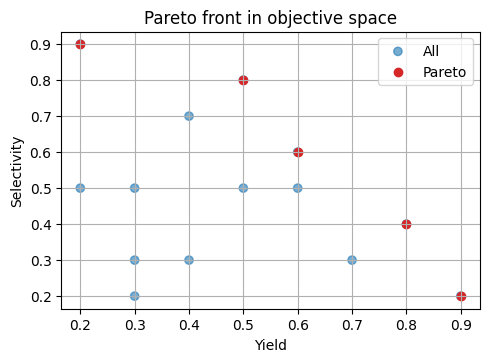

In [2]:
# 1.1 Simple dominance and Pareto front in 2D
def pareto_mask(Y: np.ndarray) -> np.ndarray:
    """Return a boolean mask for nondominated rows of Y to maximize both columns."""
    n = Y.shape[0]
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not keep[i]:
            continue
        dominates = np.all(Y[i] >= Y, axis=1) & np.any(Y[i] > Y, axis=1)
        keep[dominates] = False
        keep[i] = True
    return keep

Y_demo = np.array([
    [0.2, 0.9],[0.6, 0.6],
    [0.9, 0.2],[0.5, 0.8],
    [0.5, 0.5],[0.4, 0.7],
    [0.7, 0.3],[0.8, 0.4],
    [0.3, 0.3], [0.2, 0.5],
    [0.6, 0.5], [0.4, 0.3],
    [0.3, 0.2], [0.3, 0.5],

])

mask = pareto_mask(Y_demo)
Y_nd = Y_demo[mask]

# Visualize
plt.scatter(Y_demo[:,0], Y_demo[:,1], c=["tab:blue"]*len(Y_demo), alpha=0.6, label="All")
plt.scatter(Y_nd[:,0], Y_nd[:,1], c="tab:red", label="Pareto")
plt.xlabel("Yield")
plt.ylabel("Selectivity")
plt.title("Pareto front in objective space")
plt.legend()
plt.show()

```{admonition} ⏰ **Exercise**

Add a new point `[0.7, 0.6]` to `Y_demo`, recompute the mask, and plot again. Which earlier nondominated points become dominated now?


```

---

## 2. Load the MOF toy dataset

We will use the provided full factorial style synthetic dataset that mimics MOF synthesis outcomes across temperature, time, concentration, solvent, and linker choice. The file includes yield, purity, and reproducibility.

We will use a synthetic MOF dataset that records MOF synthesis outcomes across temperature, time, concentration, solvent, and linker choice. The file includes yield, purity, and reproducibility:

- `yield` in $[0, 0.99]$ with noise, boosts, and failures.
- `purity` in $[0, 1]$ with discontinuities.
- `reproducibility` in $\{0.25, 0.5, 0.75, 1.0\}$.

In [3]:
# 2.1 Load the dataset
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/mof_yield_dataset.csv"
df_raw = pd.read_csv(url)
df_raw 

,smiles,temperature,time_h,concentration_M,solvent_DMF,yield,purity,reproducibility
0,O=C(O)c1ccc(cc1)C(=O)O,25,12,0.05,0,0.29,0.55,1.00
1,O=C(O)/C=C/C(=O)O,25,12,0.05,0,0.42,0.45,1.00
2,Cc1ncc[nH]1,25,12,0.05,0,0.66,0.74,1.00
3,O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1,25,12,0.05,0,0.21,0.52,0.75
4,Nc1cc(C(=O)O)ccc1C(=O)O,25,12,0.05,0,0.23,0.48,0.25
...,...,...,...,...,...,...,...,...
19995,O=C(O)c1cc(F)ccc1C(=O)O,160,120,0.50,1,0.29,0.46,0.50
19996,O=C(O)c1ccc2cccc(C(=O)O)c2c1,160,120,0.50,1,0.51,0.40,0.50
19997,O=C(O)c1cccc2c1ccc(C(=O)O)c2,160,120,0.50,1,0.52,0.32,0.50
19998,O=C(O)c1ccc(cc1)-c2ccc(cc2)C(=O)O,160,120,0.50,1,0.58,0.18,0.50


The reaction parameters include:
   1) temperature (°C): 10 levels -> `[25, 40, 55, 70, 85, 100, 115, 130, 155, 160]`
   2) time_h (hours): 10 levels -> `[12, 24, ..., 120]`
   3) concentration_M (M): 10 levels -> `[0.05, 0.10, ..., 0.50]`
   4) solvent_DMF: one-hot binary {`0`=H2O, `1`=dimethyl foramide}
   5) organic linker (10 choices), such as `Fumaric acid`, `Trimesic acid`, and `Benzimidazole`.

In [4]:
df = df_raw.sample(20000, random_state=0).reset_index(drop=True) # we use full set for now

cols_with_few_values = ['temperature', 'time_h', 'concentration_M', 'solvent_DMF']

desc_catlike = (
    df_raw
    .assign(**{c: df_raw[c].astype('category') for c in cols_with_few_values})
    [ ['smiles'] + cols_with_few_values ]
    .describe(include='all').T[['count','unique','top','freq']]
)

desc_catlike

,count,unique,top,freq
smiles,20000,10,O=C(O)c1ccc(cc1)C(=O)O,2000
temperature,20000,10,25,2000
time_h,20000,10,12,2000
concentration_M,20000.0,10.0,0.05,2000.0
solvent_DMF,20000,2,0,10000


In [5]:
# How many linkers and a quick count
linker_counts = df["smiles"].value_counts()
linker_counts.head(10), "n_linkers:", df["smiles"].nunique()

(smiles
 Nc1cc(C(=O)O)ccc1C(=O)O              2000
 O=C(O)/C=C/C(=O)O                    2000
 O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1       2000
 O=C(O)c1cccc2c1ccc(C(=O)O)c2         2000
 O=C(O)c1ccc2cccc(C(=O)O)c2c1         2000
 O=C(O)c1ccc(cc1)C(=O)O               2000
 O=C(O)c1ccc(cc1)-c2ccc(cc2)C(=O)O    2000
 O=C(O)c1cc(F)ccc1C(=O)O              2000
 Cc1ncc[nH]1                          2000
 c1ccc2[nH]cnc2c1                     2000
 Name: count, dtype: int64,
 'n_linkers:',
 10)

---

## 3. Feature engineering for multiobjective modeling

We will build a light feature set using both synthesis conditions and molecular structure information. This compact design provides chemical and process context without relying on heavy cheminformatics toolkits.

### 3.1 Minimal numeric features

We begin with numeric synthesis parameters that directly influence material outcomes:
`temperature`, `time_h`, `concentration_M`, and `solvent_DMF`.
These are copied into a numeric feature frame:

In [6]:
num_cols = ["temperature", "time_h", "concentration_M", "solvent_DMF"]
X_num = df[num_cols].astype(float).copy()
X_num 

,temperature,time_h,concentration_M,solvent_DMF
0,160.0,72.0,0.35,1.0
1,55.0,60.0,0.50,0.0
2,155.0,48.0,0.15,0.0
3,160.0,72.0,0.30,1.0
4,55.0,84.0,0.30,0.0
...,...,...,...,...
19995,115.0,72.0,0.35,0.0
19996,160.0,108.0,0.15,0.0
19997,85.0,120.0,0.15,0.0
19998,100.0,48.0,0.50,1.0


### 3.2 One-hot encoding for SMILES

The SMILES column lists discrete molecular structures.
To make this information usable by machine learning models, we convert it into a numeric form through **one-hot encoding**.

One-hot encoding creates a binary vector for each category:

- Each unique SMILES gets its own column.

- A value of `1` marks the presence of that molecule in a given row, and `0` otherwise.

This prevents the model from interpreting SMILES identifiers as ordinal numbers while preserving molecular identity.

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Define encoder
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform SMILES into binary vectors
smiles_encoded = enc.fit_transform(df[['smiles']])

# Retrieve encoded column names
smiles_feature_names = enc.get_feature_names_out(['smiles'])

# Build DataFrame for encoded SMILES
X_smiles = pd.DataFrame(smiles_encoded, columns=smiles_feature_names, index=df.index)

# Combine numeric and encoded features
X = pd.concat([X_num, X_smiles], axis=1)


print(X.shape, X.columns[:10].tolist())
X.head(3)


(20000, 14) ['temperature', 'time_h', 'concentration_M', 'solvent_DMF', 'smiles_Cc1ncc[nH]1', 'smiles_Nc1cc(C(=O)O)ccc1C(=O)O', 'smiles_O=C(O)/C=C/C(=O)O', 'smiles_O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1', 'smiles_O=C(O)c1cc(F)ccc1C(=O)O', 'smiles_O=C(O)c1ccc(cc1)-c2ccc(cc2)C(=O)O']


,temperature,time_h,concentration_M,solvent_DMF,smiles_Cc1ncc[nH]1,smiles_Nc1cc(C(=O)O)ccc1C(=O)O,smiles_O=C(O)/C=C/C(=O)O,smiles_O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1,smiles_O=C(O)c1cc(F)ccc1C(=O)O,smiles_O=C(O)c1ccc(cc1)-c2ccc(cc2)C(=O)O,smiles_O=C(O)c1ccc(cc1)C(=O)O,smiles_O=C(O)c1ccc2cccc(C(=O)O)c2c1,smiles_O=C(O)c1cccc2c1ccc(C(=O)O)c2,smiles_c1ccc2[nH]cnc2c1
0,160.0,72.0,0.35,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,60.0,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,155.0,48.0,0.15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3 Targets for multiobjective learning

We will form a 3 objective vector:
- $f_1$: `yield` to maximize.
- $f_2$: `purity` to maximize.
- $f_3$: numeric reproducibility where higher is better.

In [8]:
# 3.4 Target matrix
Y = df[["yield","purity","reproducibility"]].astype(float).values
print(Y.min(axis=0), Y.max(axis=0))
Y

[0.   0.08 0.25] [0.99 0.94 1.  ]


array([[0.  , 0.17, 0.25],
       [0.49, 0.41, 0.5 ],
       [0.43, 0.26, 0.5 ],
       ...,
       [0.19, 0.75, 0.25],
       [0.33, 0.68, 1.  ],
       [0.28, 0.48, 0.5 ]], shape=(20000, 3))

---
## 4. Pareto utilities and hypervolume in 2D

This section builds intuition for multiobjective comparison using two outcomes at a time before returning to three. 


We use $f_1=$ = yield and $f_2=$  = purity. The goal is to identify the subset of experiments that are not outperformed by any other experiment across both objectives. These are the candidates on the Pareto front. Working in 2D makes it easy to see which points survive and how much area of the objective space they dominate relative to a chosen reference.

```{admonition} Note
Note that in reality, we usually start with only a couple of experiments. So we will show the case for both **50** experiment and the full dataset (**20000** experiments).
```

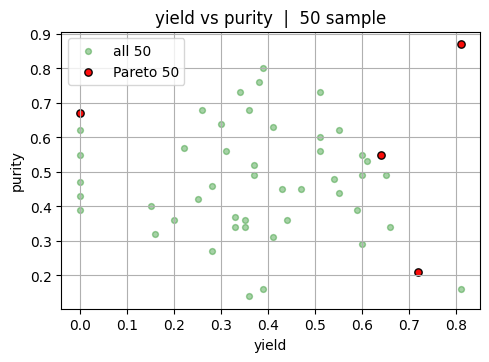

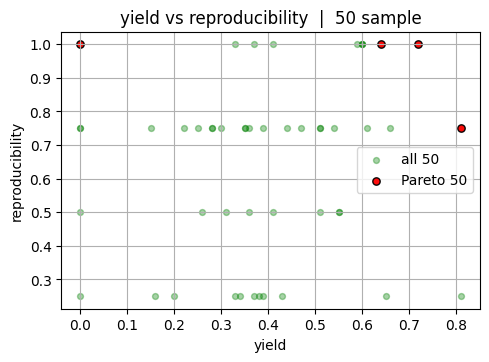

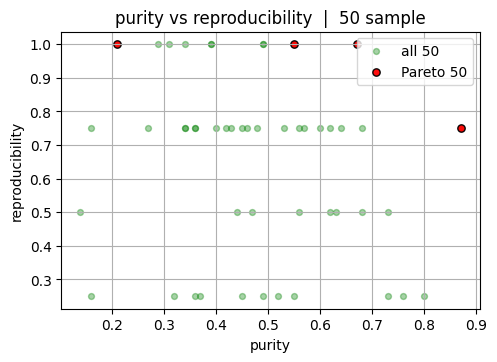

In [9]:
def nondominated_mask(F: np.ndarray) -> np.ndarray:
    """
    Non dominated set for maximization.
    F: shape (n_points, n_obj)
    Returns boolean mask where True means non dominated.
    """
    F = np.asarray(F)
    n = F.shape[0]
    mask = np.ones(n, dtype=bool)
    for i in range(n):
        if not mask[i]:
            continue
        dominates_i = ((F >= F[i]).all(axis=1) & (F > F[i]).any(axis=1))
        dominates_i[i] = False
        if np.any(dominates_i):
            mask[i] = False
    return mask


pairs = [(0, 1), (0, 2), (1, 2)]
labels = ["yield", "purity", "reproducibility"]


 # 50 experiment sample: pairwise plots
rng = np.random.default_rng(0)
idx_50 = rng.choice(Y.shape[0], size=50, replace=False)
Y50 = Y[idx_50]

mask_50 = nondominated_mask(Y50)
front_50 = Y50[mask_50]

for i, j in pairs:
    plt.scatter(Y50[:, i], Y50[:, j], s=18, color = "green", alpha=0.35, label="all 50")
    plt.scatter(front_50[:, i], front_50[:, j], color = "red", s=28, alpha=0.95, label="Pareto 50", edgecolor="k")
    plt.xlabel(labels[i]); plt.ylabel(labels[j])
    plt.title(f"{labels[i]} vs {labels[j]}  |  50 sample")
    plt.legend()
    plt.show()

Now let's look at the full dataset. Again, note that in reality you will not be able to see this "final answer."

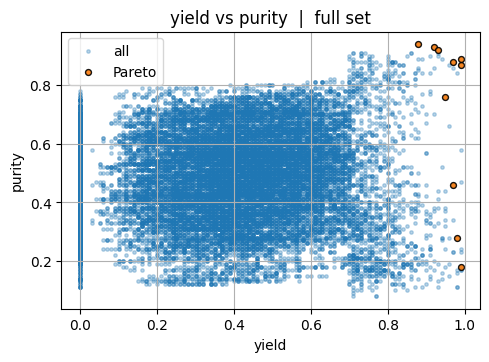

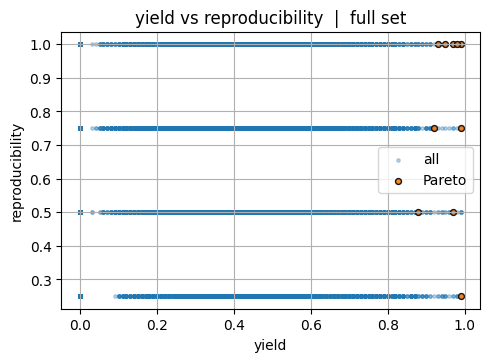

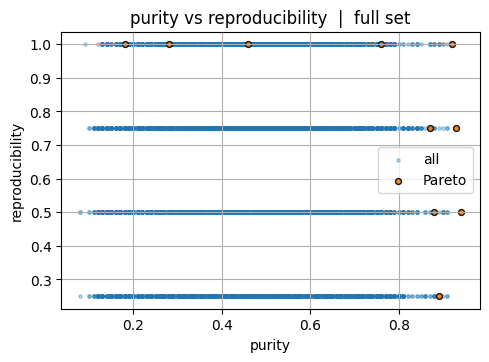

In [10]:
# Full set: pairwise plots
mask_full = nondominated_mask(Y)
front_full = Y[mask_full]


for i, j in pairs:
    plt.scatter(Y[:, i], Y[:, j], s=6, alpha=0.3, label="all")
    plt.scatter(front_full[:, i], front_full[:, j], s=18, alpha=0.9, label="Pareto", edgecolor="k")
    plt.xlabel(labels[i]); plt.ylabel(labels[j])
    plt.title(f"{labels[i]} vs {labels[j]}  |  full set")
    plt.legend()
    plt.show()       

Next, we talk about an important idea, **hypervolume (HV)** which is the volume of the dominated region bounded by a reference point $r$. It is a way to measure how much of the “good” region of objective space is covered by your Pareto front. In two objectives (for example, `yield` and `purity`), each experiment corresponds to a point. The Pareto front marks those points that are not outperformed by any other in both metrics. The hypervolume is then the total area (or volume in higher dimensions) between that front and a chosen **reference point**.

```{admonition} Note
You can think of it as the portion of the map where the model or experiments are doing well. If your Pareto front moves outward toward higher yield and purity, the dominated region expands, and the hypervolume increases. A larger hypervolume means better overall trade offs across objectives.
```

The reference point defines the lower bound of the region you measure against. It must be **worse than all observed points** in every objective because hypervolume represents improvement relative to that point. For yield and purity, which are maximized, this means picking a reference near the bottom left corner of the plot.

If all your data are normalized between 0 and 1, the natural choice is `(0, 0)` — representing the absolute worst case (zero yield, zero purity). You can also use `(0.2, 0.2)` or another slightly higher reference if you want to focus only on improvements beyond a minimum acceptable performance threshold. That reference would mean: “We only care about the area above 20% yield and 20% purity.”

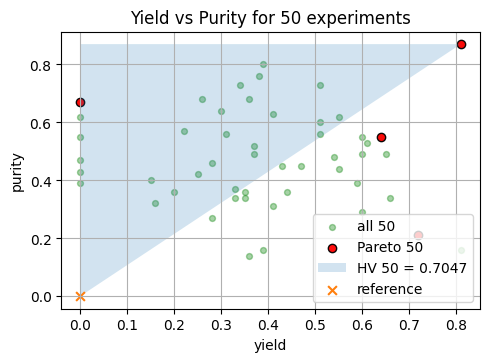

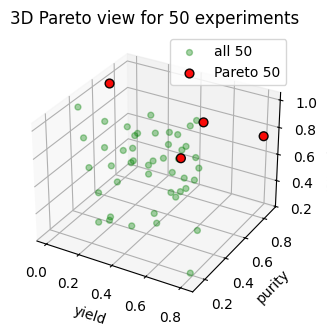

In [11]:
def staircase_polygon_2d(front_2d: np.ndarray, ref=(0.0, 0.0)):
    """
    Build polygon that represents the dominated region up to ref for maximization in 2D.
    Returns xs, ys ready for plt.fill.
    """
    F = front_2d[np.argsort(-front_2d[:, 0])]   # sort by x (f1) descending
    y_env = np.maximum.accumulate(F[:, 1])       # envelope in y (f2)
    xs = np.concatenate([[ref[0]], F[:, 0], [ref[0]]])
    ys = np.concatenate([[ref[1]], y_env,    [y_env[-1]]])
    return xs, ys

def hypervolume_2d(front_2d: np.ndarray, ref=(0.0, 0.0)) -> float:
    """
    Hypervolume in 2D for maximization.
    """
    F = front_2d[np.argsort(-front_2d[:, 0])]
    y_env = np.maximum.accumulate(F[:, 1])
    xs = np.concatenate([F[:, 0], [ref[0]]])
    ys = np.concatenate([y_env,   [y_env[-1]]])
    widths = np.maximum(0.0, xs[:-1] - xs[1:])
    heights = np.maximum(0.0, ys[:-1] - ref[1])
    return float(np.sum(widths * heights))

# Pareto front for the 50 set
mask50 = nondominated_mask(Y50)
front50 = Y50[mask50]

front50.shape, mask50.sum()


# 2D plot for the 50 experiment set
ref = (0.0, 0.0)  # adjust if your outcomes are not in [0, 1]

F2_50 = front50[:, [0, 1]]
hv_50 = hypervolume_2d(F2_50, ref=ref)

plt.scatter(Y50[:, 0], Y50[:, 1], s=18,  color = "green",alpha=0.35, label="all 50")
plt.scatter(front50[:, 0], front50[:, 1], s=36, alpha=0.95, color = "red", label="Pareto 50", edgecolor="k")

xs50, ys50 = staircase_polygon_2d(F2_50, ref=ref)
plt.fill(xs50, ys50, alpha=0.2, label=f"HV 50 = {hv_50:.4f}")
plt.scatter([ref[0]], [ref[1]], s=40, marker="x", label="reference")

plt.xlabel("yield")
plt.ylabel("purity")
plt.title("Yield vs Purity for 50 experiments")
plt.legend()
plt.show()

# 3D plot for the 50 experiment set
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y50[:, 0], Y50[:, 1], Y50[:, 2], s=18, color = "green", alpha=0.35, label="all 50")
ax.scatter(front50[:, 0], front50[:, 1], front50[:, 2], color = "red", s=40, alpha=0.95, label="Pareto 50", edgecolor="k")

ax.set_xlabel("yield")
ax.set_ylabel("purity")
ax.set_zlabel("reproducibility")
ax.set_title("3D Pareto view for 50 experiments")
ax.legend()
plt.show()

Let's assume we run 3 additional experiments and we are so lucky that they achieve strong outcomes around high yield and purity (`[0.90, 0.80, 0.70]`, `[0.92, 0.78, 0.75]`, and ` [0.88, 0.82, 0.65]`). 

We can take a look at the change to the hypervolume:

HV (old 50) = 0.704700 | HV (updated 53) = 0.793700 | ΔHV = 0.089000


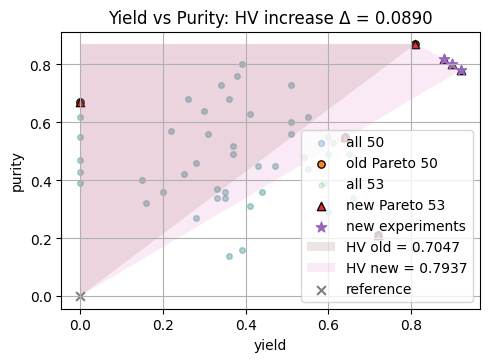

In [12]:
# 1) Simulate three new high-performing experiments and append to the 50-set
#    We keep reproducibility reasonable; adjust as needed based on your context.
new_points = np.array([
    [0.90, 0.80, 0.70],
    [0.92, 0.78, 0.75],
    [0.88, 0.82, 0.65],
], dtype=float)

Y50_updated = np.vstack([Y50, new_points])

# Recompute Pareto front for the updated 50+3 set
mask50_new = nondominated_mask(Y50_updated)
front50_new = Y50_updated[mask50_new]

front50.shape, front50_new.shape
# 2) Hypervolume before vs after on yield-purity (2D)
ref = (0.0, 0.0)  # same reference as before

F2_old = front50[:, [0, 1]]
F2_new = front50_new[:, [0, 1]]

hv_old = hypervolume_2d(F2_old, ref=ref)
hv_new = hypervolume_2d(F2_new, ref=ref)
delta_hv = hv_new - hv_old

print(f"HV (old 50) = {hv_old:.6f} | HV (updated 53) = {hv_new:.6f} | ΔHV = {delta_hv:.6f}")
# 3) 2D visualization: overlay old HV region, new HV region, and highlight new points
plt.scatter(Y50[:, 0], Y50[:, 1], s=18, alpha=0.25, label="all 50")
plt.scatter(front50[:, 0], front50[:, 1], s=28, alpha=0.95, label="old Pareto 50", edgecolor="k")

# Updated points and front
plt.scatter(Y50_updated[:, 0], Y50_updated[:, 1], s=12, alpha=0.15, label="all 53")
plt.scatter(front50_new[:, 0], front50_new[:, 1], s=36, alpha=0.95, label="new Pareto 53", marker='^', edgecolor="k")

# Highlight just the three new experiments
plt.scatter(new_points[:, 0], new_points[:, 1], s=60, label="new experiments", marker='*')

# Fill old HV region
xs_old, ys_old = staircase_polygon_2d(F2_old, ref=ref)
plt.fill(xs_old, ys_old, alpha=0.15, label=f"HV old = {hv_old:.4f}")

# Fill new HV region
xs_new, ys_new = staircase_polygon_2d(F2_new, ref=ref)
plt.fill(xs_new, ys_new, alpha=0.15, label=f"HV new = {hv_new:.4f}")

plt.scatter([ref[0]], [ref[1]], s=40, marker="x", label="reference")

plt.xlabel("yield")
plt.ylabel("purity")
plt.title(f"Yield vs Purity: HV increase Δ = {delta_hv:.4f}")
plt.legend()
plt.show()

From above plot, we see that the **hypervolume increase** equals the additional “good” region covered by the improved front. Using the same reference point keeps comparisons fair. In synthesis terms, this reflects the *net expansion of acceptable performance space when higher yield and purity conditions are discovered*.

We can compare with the full dataset, and this give you an idea of the maxiumn hypervolume you can achieve. But, again, keep in mind that the entire space / synthesis-yield relationship is usually a blackbox function and you won't know the max hypervolume.

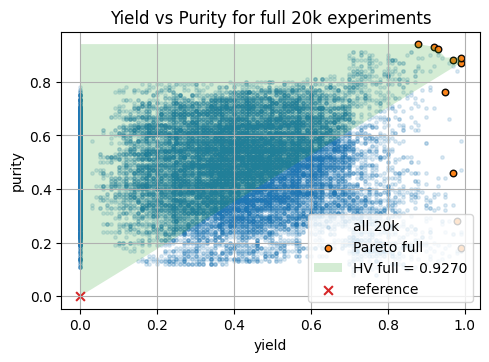

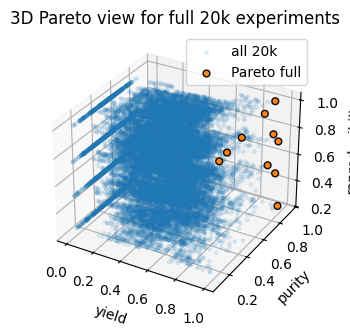

Hypervolume wrt ref (0.0, 0.0): 50 = 0.704700  |  full = 0.927000


In [13]:
# Full set Pareto front and 2D plot
mask_full = nondominated_mask(Y)
front_full = Y[mask_full]

F2_full = front_full[:, [0, 1]]
hv_full = hypervolume_2d(F2_full, ref=ref)

plt.scatter(Y[:, 0], Y[:, 1], s=6, alpha=0.15, label="all 20k")
plt.scatter(front_full[:, 0], front_full[:, 1], s=22, alpha=0.95, label="Pareto full", edgecolor="k")

xs_full, ys_full = staircase_polygon_2d(F2_full, ref=ref)
plt.fill(xs_full, ys_full, alpha=0.2, label=f"HV full = {hv_full:.4f}")
plt.scatter([ref[0]], [ref[1]], s=40, marker="x", label="reference")

plt.xlabel("yield")
plt.ylabel("purity")
plt.title("Yield vs Purity for full 20k experiments")
plt.legend()
plt.show()



# 3D plot for the full set
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], s=6, alpha=0.1, label="all 20k")
ax.scatter(front_full[:, 0], front_full[:, 1], front_full[:, 2], s=24, alpha=0.95, label="Pareto full", edgecolor="k")

ax.set_xlabel("yield")
ax.set_ylabel("purity")
ax.set_zlabel("reproducibility")
ax.set_title("3D Pareto view for full 20k experiments")
ax.legend()
plt.show()

print(f"Hypervolume wrt ref {ref}: 50 = {hv_50:.6f}  |  full = {hv_full:.6f}")

---
## 5. Scalarization and surrogate models for each objective


A common way to turn multiple objectives into one is **weighted sum**:
$$
s_w(x) = \sum_{j=1}^m w_j \,\tilde f_j(x)
$$
with $w_j \ge 0$ and $\sum_j w_j = 1$, where $\tilde f_j$ are normalized objectives. This is fast and easy to implement.

> Caution: linear scalarization can miss non-convex parts of the Pareto front. Still, it is a practical baseline and pairs well with BO.





We now assume we only have a 50 point subset in hand. All modeling, selection, and validation in this section uses only `X50` and `Y50`. The idea is simple: fit one surrogate per objective on the training split of these 50 points, evaluate on the held out split, and then use a scalarized acquisition to propose new experiments from the same 50 point design space.


### 5.1 Train test split and scaling

In [14]:
Y50 = Y[idx_50]
X50 = np.asarray(X)[idx_50]  
# Train test split within the 50 points
X_train, X_test, Y_train, Y_test = train_test_split(
    np.asarray(X50), np.asarray(Y50), test_size=0.2, random_state=0
)

# Standardize features using only training data
scaler_X = StandardScaler().fit(X_train)
Xtr = scaler_X.transform(X_train)
Xte = scaler_X.transform(X_test)

Ytr = Y_train.copy()
Yte = Y_test.copy()

Xtr.shape, Ytr.shape

((40, 14), (40, 3))

### 5.2 Three GPs with Matern on the 50 point split
Here we fit one GP per objective on `Xtr, Ytr`. We use a Matern kernel with a small white noise term for numerical stability. Scores are printed on `Xte, Yte`. GPs are flexible and give calibrated uncertainties for acquisition functions. On larger feature sets they can be slow, which is why we also show Random Forests.

```{admonition} Note
Recall, the kernel is a function that defines the covariance or similarity between data points, determining how the Gaussian Process generalizes from the training data.
```

In [15]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.metrics import r2_score, mean_absolute_error

kernel = C(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-3)

gps = []
for m in range(Ytr.shape[1]):
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2, random_state=m)
    gpr.fit(Xtr, Ytr[:, m])
    gps.append(gpr)

for m, name in enumerate(["yield", "purity", "reproducibility"]):
    pred = gps[m].predict(Xte)
    print(name, "R2:", r2_score(Yte[:, m], pred), "MAE:", mean_absolute_error(Yte[:, m], pred))


yield R2: -0.8404770597465006 MAE: 0.18228080760227366
purity R2: 0.32667907075696856 MAE: 0.08269839267071963
reproducibility R2: 0.020932330074736827 MAE: 0.13847277467947322


### 5.3 RF trio trained only on the 50 point split

Here we train three RF models on `Xtr, Ytr` and score on `Xte, Yte`. RFs scale well and give a simple uncertainty proxy from the spread across trees, which we will use for acquisition.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

rfs = []
for m in range(Ytr.shape[1]):
    rf = RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=5,
        random_state=10 + m,
        n_jobs=-1
    )
    rf.fit(Xtr, Ytr[:, m])
    rfs.append(rf)

for m, name in enumerate(["yield", "purity", "reproducibility"]):
    pred = rfs[m].predict(Xte)
    print(name, "R2:", r2_score(Yte[:, m], pred), "MAE:", mean_absolute_error(Yte[:, m], pred))

yield R2: -0.22743401927091833 MAE: 0.1859363583750202
purity R2: 0.4381175325313328 MAE: 0.07596276151139311
reproducibility R2: -0.10448172092762897 MAE: 0.13657568665961647


We see that due to limited data size, both GP and RF surrogate models have a poor R2 value.

```{admonition} Note
Use RF surrogates when the dataset is larger or when GP training is slow. RF also gives a simple uncertainty proxy from the spread across trees, which we will use later for bandit style decisions.
```

---

## 6. Acquisition for multiobjective BO

We now simulate planning within the 50 point space. Think of each of the 50 rows as a candidate experiment. At each iteration we will:

1) fit the three RF surrogates on the experiments already “run” (a small seed set from the 50),
2) evaluate a scalarized acquisition on a candidate cloud sampled from `Xtr`,
3) propose the single best next point, and
4) emulate an outcome by nearest neighbor lookup inside the same 50 point training pool.

This is a pool based simulation that stays within the 50 points you actually have. We also track an approximate 3D hypervolume of the observed set, using a crude Monte Carlo estimate in the unit cube for quick feedback.

In [17]:
# Utilities for candidate cloud and scalarized EI
from typing import Tuple
from scipy.stats import norm

def candidate_cloud(Xbase: np.ndarray, n: int = 2000, seed: int = 0) -> np.ndarray:
    rng = np.random.RandomState(seed)
    idx = rng.choice(Xbase.shape[0], size=min(n, Xbase.shape[0]), replace=False)
    return Xbase[idx]

def rf_mu_sigma(model: RandomForestRegressor, Xc: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    preds = np.stack([est.predict(Xc) for est in model.estimators_], axis=1)
    return preds.mean(axis=1), preds.std(axis=1) + 1e-6

def ei_from_mu_sigma(mu: np.ndarray, sd: np.ndarray, best: float, xi: float = 0.01) -> np.ndarray:
    sd = np.maximum(sd, 1e-12)
    z = (mu - best - xi) / sd
    return (mu - best - xi) * norm.cdf(z) + sd * norm.pdf(z)

def sample_simplex(M: int) -> np.ndarray:
    return np.random.dirichlet(alpha=np.ones(M))
    
def hv_approx_3d(Ym: np.ndarray, ref: np.ndarray, n_ref: int = 4000, seed: int = 0) -> float:
    # crude Monte Carlo hypervolume estimate over [ref, 1]^3 for maximization
    rng = np.random.RandomState(seed)
    U = rng.uniform(low=ref, high=np.array([1, 1, 1]), size=(n_ref, 3))
    mask = np.zeros(n_ref, dtype=bool)
    for y in Ym[nondominated_mask(Ym)]:
        mask |= np.all(U <= y, axis=1)
    return mask.mean() * np.prod(1 - ref)

# Run a few scalarized BO steps on the 50 point pool

rng = np.random.RandomState(7)

# Candidate cloud drawn from the 50 point training pool
Xc = candidate_cloud(Xtr, n=2000, seed=2)

# Start with 8 random seed experiments from the 50 training rows
seed_idx = rng.choice(Xtr.shape[0], size=8, replace=False)
D_X = Xtr[seed_idx]
D_Y = Ytr[seed_idx]

history_hv = []
ref_point = np.array([0.0, 0.0, 0.0])

# Track initial HV
history_hv.append(hv_approx_3d(D_Y, ref_point, n_ref=5000, seed=1))

n_rounds = 3 # you can change it to 15, for html purpose we use 3
for t in range(n_rounds):
    # Refit RF surrogates on the current observed subset
    for m in range(3):
        rfs[m].fit(D_X, D_Y[:, m])

    # Predict mean and uncertainty on the candidate cloud
    mu_list, sd_list = [], []
    for m in range(3):
        mu_m, sd_m = rf_mu_sigma(rfs[m], Xc)
        mu_list.append(mu_m); sd_list.append(sd_m)
    MU = np.column_stack(mu_list)
    SD = np.column_stack(sd_list)

    # Random scalarization weights on the simplex
    w = sample_simplex(3)

    # Scalarized mean and scalarized EI baseline
    g_mu = MU @ w
    mu_D = np.column_stack([rfs[m].predict(D_X) for m in range(3)])
    best_g = float((mu_D @ w).max())

    # Scalarized uncertainty under independence approximation
    g_sd = np.sqrt(np.maximum(1e-8, np.sum((SD * w) ** 2, axis=1)))

    # EI on scalarized surrogate
    acq = ei_from_mu_sigma(g_mu, g_sd, best=best_g, xi=0.01)

    # Pick next candidate
    j = int(np.argmax(acq))
    x_next = Xc[j:j+1]

    # Emulate measurement by nearest neighbor in the 50 training pool
    k = int(np.argmin(np.linalg.norm(Xtr - x_next, axis=1)))
    y_next = Ytr[k:k+1]

    # Update observed set
    D_X = np.vstack([D_X, x_next])
    D_Y = np.vstack([D_Y, y_next])

    # Track 3D HV
    hv_now = hv_approx_3d(D_Y, ref_point, n_ref=3000, seed=100 + t)
    history_hv.append(hv_now)

print("Observed points:", D_X.shape[0], "Final approx HV:", history_hv[-1])


Observed points: 11 Final approx HV: 0.31266666666666665


We seed with a handful of points from `Xtr, Ytr`. Each round we refit the RF trio on the current observed set, score a candidate cloud from `Xtr` using random scalarization with EI, pick the best candidate, and emulate the measurement by nearest neighbor lookup inside `Xtr` to fetch its `Ytr`. Hypervolume in 3D is tracked after each addition.


The curve below shows how the approximate 3D hypervolume grows as the loop adds points selected by random scalarization with EI. This is a quick way to judge whether the front is expanding within the 50 point design space.

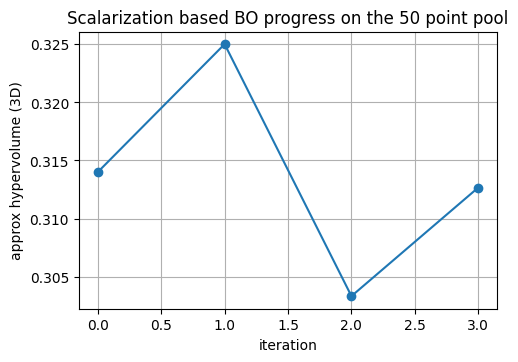

In [18]:
plt.plot(history_hv, marker="o")
plt.xlabel("iteration")
plt.ylabel("approx hypervolume (3D)")
plt.title("Scalarization based BO progress on the 50 point pool")
plt.show()

---

---

## 7. End to end MOBO loop on the MOF dataset

We now put everything together as a small, complete multiobjective active learning loop that starts from 50 points and grows by proposing 10 new points per round for 15 rounds. The goal is to expand the Pareto set over yield, purity, and reproducibility while tracking a clear 2D hypervolume on yield and purity.

Choices in this section:
- Surrogate: one Gaussian Process per objective
- Acquisition: random candidate cloud, scalarization with fixed equal weights, and Expected Improvement on the scalarized objective
- Weights: fixed at `[0.33, 0.33, 0.33]` for the entire run to keep behavior easy to interpret
- Evaluation: adding the selected pool rows directly, which emulates running the real experiments

We will show the following results:
- Iteration prints with the scalarized EI top scores
- The three best proposed conditions per round
- A four panel figure with hypervolume trace and per objective best so far curves
- A separate plot comparing the yield vs purity Pareto front at the start and at the end

In [19]:
# === 7. End to end MOBO with a strict oracle and discrete search space ===
from typing import Any, Tuple, Dict, List, Callable
from itertools import product

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.stats import norm

# ---------------------------
# 0) Define the discrete reaction space and ligand catalog
# ---------------------------

# Knob grids (exact discrete levels)
TEMP_GRID = [25, 40, 55, 70, 85, 100, 115, 130, 155, 160]                    # 10 levels
TIME_GRID = [12, 24, 36, 48, 60, 72, 84, 96, 108, 120]                        # 10 levels
CONC_GRID = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]      # 10 levels
DMF_GRID  = [0, 1]                                                             # H2O or DMF

# Ligand catalog: (name, smiles, MW, logP, TPSA, n_rings, family)
LIGANDS = [
    ("H2BDC", "O=C(O)c1ccc(cc1)C(=O)O", 166.13, 1.2, 75.0, 1, "BDC"),
    ("Fumaric acid", "O=C(O)/C=C/C(=O)O", 116.07, -0.6, 75.0, 0, "Aliphatic diacid"),
    ("2-methylimidazole", "Cc1ncc[nH]1", 82.10, 0.2, 29.0, 1, "Azole"),
    ("Trimesic acid", "O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1", 210.14, 1.4, 112.0, 1, "Triacid"),
    ("H2BDC-NH2", "Nc1cc(C(=O)O)ccc1C(=O)O", 181.15, 1.0, 101.0, 1, "BDC"),
    ("H2BDC-F", "O=C(O)c1cc(F)ccc1C(=O)O", 184.13, 1.4, 75.0, 1, "BDC"),
    ("1,4-NDC", "O=C(O)c1ccc2cccc(C(=O)O)c2c1", 216.19, 2.0, 75.0, 2, "Naphthalene diacid"),
    ("2,6-NDC", "O=C(O)c1cccc2c1ccc(C(=O)O)c2", 216.19, 2.0, 75.0, 2, "Naphthalene diacid"),
    ("4,4'-BPDC", "O=C(O)c1ccc(cc1)-c2ccc(cc2)C(=O)O", 242.23, 2.5, 75.0, 2, "Biphenyl diacid"),
    ("Benzimidazole", "c1ccc2[nH]cnc2c1", 118.14, 1.3, 25.0, 2, "Azole"),
]
SMILES_LIST = [s for (_, s, *_rest) in LIGANDS]

# ---------------------------
# 1) Validate df matches the discrete space exactly (assertions)
# ---------------------------

# Ensure df has required columns
req_cols = ["temperature","time_h","concentration_M","solvent_DMF","smiles","yield","purity","reproducibility"]
missing = [c for c in req_cols if c not in df.columns]
if missing:
    raise ValueError(f"df missing columns: {missing}")

# Assert discrete levels match
assert set(df["temperature"].unique())      <= set(TEMP_GRID), "df temperature outside allowed grid"
assert set(df["time_h"].unique())           <= set(TIME_GRID), "df time_h outside allowed grid"
assert set(df["concentration_M"].unique())  <= set(CONC_GRID), "df concentration_M outside allowed grid"
assert set(df["solvent_DMF"].unique())      <= set(DMF_GRID),  "df solvent_DMF outside allowed grid"
assert set(df["smiles"].unique())           <= set(SMILES_LIST), "df smiles not in ligand list"

# check full cross count
assert len(df) == 20000

# ---------------------------
# 2) Build search_space and the oracle from df
#    search_space: list of valid tuples (T, time, conc, dmf, smiles)
#    run_experiment(choice): returns (yield, purity, reproducibility)
# ---------------------------

# Build mapping from key -> outcomes using df (ground truth)
key_to_y: Dict[Tuple[Any,Any,Any,Any,Any], Tuple[float,float,float]] = {}
for r in df[["temperature","time_h","concentration_M","solvent_DMF","smiles","yield","purity","reproducibility"]].itertuples(index=False, name=None):
    T, tt, cc, d, smi, y1, y2, y3 = r
    key_to_y[(T, tt, cc, d, smi)] = (float(y1), float(y2), float(y3))

# Build search_space strictly from the CARTESIAN PRODUCT of allowed levels and ligands
# and filter to keys that actually exist in df (robust to any missing combos)
search_space: List[Tuple[Any,Any,Any,Any,Any]] = []
for T, tt, cc, d, smi in product(TEMP_GRID, TIME_GRID, CONC_GRID, DMF_GRID, SMILES_LIST):
    key = (T, tt, cc, d, smi)
    if key in key_to_y:
        search_space.append(key)

# Oracle the BO will call. No direct df reads elsewhere.
def run_experiment(choice: Tuple[Any,Any,Any,Any,Any]) -> Tuple[float,float,float]:
    """
    Accepts only a 5-tuple:
      (temperature, time_h, concentration_M, solvent_DMF, smiles)
    Returns the true outcomes (yield, purity, reproducibility).
    Raises KeyError if choice is not in the dataset-backed search space.
    """
    return key_to_y[choice]

# Build a map from choice -> position in search_space (for indexing)
key_to_pos: Dict[Tuple[Any,Any,Any,Any,Any], int] = {
    key: i for i, key in enumerate(search_space)
}

# Map your df row indices in idx_50 to positions in search_space
initial_idx = np.array([
    key_to_pos[
        (df.loc[i,"temperature"], df.loc[i,"time_h"], df.loc[i,"concentration_M"], df.loc[i,"solvent_DMF"], df.loc[i,"smiles"])
    ] for i in idx_50
], dtype=int)

# ---------------------------
# 3) Featurization of choices (no class)
# ---------------------------

# Fit OneHot on smiles across the whole search_space
smiles_col = np.array([[key[4]] for key in search_space])  # shape (N, 1)
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe.fit(smiles_col)

def choice_to_vector(choice: Tuple[Any,Any,Any,Any,Any]) -> np.ndarray:
    T, tt, cc, d, smi = choice
    num = np.array([float(T), float(tt), float(cc), float(d)], dtype=float)
    smi_vec = ohe.transform(np.array([[smi]]))[0]
    return np.concatenate([num, smi_vec], axis=0)

def choices_to_matrix(choices: List[Tuple[Any,Any,Any,Any,Any]]) -> np.ndarray:
    num_block = np.array([[float(c[0]), float(c[1]), float(c[2]), float(c[3])] for c in choices], dtype=float)
    smi_block = ohe.transform(np.array([[c[4]] for c in choices]))
    return np.hstack([num_block, smi_block])

# ---------------------------
# 4) Pareto + hypervolume helpers on (yield, purity)
# ---------------------------

def nondominated_mask(F: np.ndarray) -> np.ndarray:
    F = np.asarray(F)
    n = F.shape[0]
    mask = np.ones(n, dtype=bool)
    for i in range(n):
        if not mask[i]:
            continue
        dom = ((F >= F[i]).all(axis=1) & (F > F[i]).any(axis=1))
        dom[i] = False
        if np.any(dom):
            mask[i] = False
    return mask

def hypervolume_2d(front_2d: np.ndarray, ref=(0.0, 0.0)) -> float:
    F = front_2d[np.argsort(-front_2d[:, 0])]
    y_env = np.maximum.accumulate(F[:, 1])
    xs = np.concatenate([F[:, 0], [ref[0]]])
    ys = np.concatenate([y_env,   [y_env[-1]]])
    widths  = np.maximum(0.0, xs[:-1] - xs[1:])
    heights = np.maximum(0.0, ys[:-1] - ref[1])
    return float(np.sum(widths * heights))

def hv_obs_2d(Y_obs: np.ndarray, ref=(0.0, 0.0)) -> float:
    Y2 = Y_obs[:, [0, 1]]
    front = Y2[nondominated_mask(Y2)]
    return hypervolume_2d(front, ref)

# ---------------------------
# 5) Scalarized EI and candidate sampling
# ---------------------------

def scalarized_ei(mu: np.ndarray, sd: np.ndarray, w: np.ndarray, y_best: float, xi: float=0.01) -> np.ndarray:
    mu_g = (mu * w.reshape(1, -1)).sum(axis=1)
    var_g = ((sd**2) * (w.reshape(1, -1)**2)).sum(axis=1)
    sd_g = np.sqrt(np.maximum(1e-12, var_g))
    z = (mu_g - y_best - xi) / sd_g
    return (mu_g - y_best - xi) * norm.cdf(z) + sd_g * norm.pdf(z)

def sample_cloud(pool_idx: np.ndarray, n: int, rng: np.random.Generator) -> np.ndarray:
    if pool_idx.size <= n:
        return pool_idx
    rel = rng.choice(pool_idx.size, size=n, replace=False)
    return pool_idx[rel]

# ---------------------------
# 6) MOBO runner using only run_experiment(choice)
# ---------------------------

def run_mobo_with_oracle(
    search_space: List[Tuple[Any,Any,Any,Any,Any]],
    run_experiment: Callable[[Tuple[Any,Any,Any,Any,Any]], Tuple[float,float,float]],
    initial_idx: np.ndarray,
    weights: np.ndarray = np.array([0.33,0.33,0.33]),
    rounds: int = 15,
    batch: int = 10,
    cloud: int = 6000,
    ref_2d: Tuple[float,float] = (0.0, 0.0),
    rng_seed: int = 11,
) -> Dict[str, Any]:
    rng = np.random.default_rng(rng_seed)
    w = np.asarray(weights, dtype=float)
    w = w / w.sum()

    # Observed and pool tracked as positions in search_space
    obs_idx = np.array(initial_idx, dtype=int)
    pool_idx = np.setdiff1d(np.arange(len(search_space)), obs_idx, assume_unique=False)

    # Evaluate oracle for initial 50
    X_obs = choices_to_matrix([search_space[i] for i in obs_idx])
    Y_obs = np.array([run_experiment(search_space[i]) for i in obs_idx], dtype=float)
    Y_start = Y_obs.copy()

    hv_trace = [hv_obs_2d(Y_obs, ref=ref_2d)]
    best3_log: List[pd.DataFrame] = []
    Y_hist: List[np.ndarray] = [Y_obs.copy()]

    for t in range(1, rounds + 1):
        # Fit GPs on observed
        scX = StandardScaler().fit(X_obs)
        Xtr = scX.transform(X_obs)

        kernel = C(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-4)
        gps = []
        for j in range(3):
            gp = GaussianProcessRegressor(
                kernel=kernel, normalize_y=True, n_restarts_optimizer=1, random_state=100 + j
            )
            gp.fit(Xtr, Y_obs[:, j])
            gps.append(gp)

        # Candidate cloud from pool indices
        if pool_idx.size == 0:
            print(f"Iter {t:02d} | pool empty, stopping.")
            break
        cand_abs = sample_cloud(pool_idx, n=min(cloud, pool_idx.size), rng=rng)
        Xc = scX.transform(choices_to_matrix([search_space[i] for i in cand_abs]))

        # Predict mean and std for each objective
        MU = []; SD = []
        for j in range(3):
            mu_j, sd_j = gps[j].predict(Xc, return_std=True)
            MU.append(mu_j); SD.append(sd_j)
        MU = np.column_stack(MU)
        SD = np.column_stack(SD)

        # EI baseline from observed
        mu_obs = np.column_stack([gps[j].predict(scX.transform(X_obs)) for j in range(3)])
        best_scalar = float((mu_obs @ w).max())

        # Scalarized EI with fixed weights
        acq = scalarized_ei(MU, SD, w=w, y_best=best_scalar, xi=0.01)

        # Pick top-k
        k = min(batch, cand_abs.size)
        pick_rel = np.argsort(-acq)[:k]
        new_abs = cand_abs[pick_rel]

        # Log top-3 choices and outcomes via oracle
        top3_abs = new_abs[: min(3, new_abs.size)]
        top3_choices = [search_space[i] for i in top3_abs]
        top3_out = np.array([run_experiment(ch) for ch in top3_choices])
        top3_df = pd.DataFrame(
            np.column_stack([top3_choices, top3_out]),
            columns=["temperature","time_h","concentration_M","solvent_DMF","smiles","yield","purity","reproducibility"]
        )
        best3_log.append(top3_df)

        print(f"Iter {t:02d} | HV={hv_trace[-1]:.4f} | selected {k}")
        for r_i in range(top3_df.shape[0]):
            row = top3_df.iloc[r_i]
            print(f"  #{r_i+1}: temp={row['temperature']}, time_h={row['time_h']}, "
                  f"conc={row['concentration_M']}, DMF={row['solvent_DMF']}, "
                  f"yield={float(row['yield']):.3f}, purity={float(row['purity']):.3f}, "
                  f"repro={float(row['reproducibility']):.3f}")

        # Feedback: call oracle for all selected
        X_new = choices_to_matrix([search_space[i] for i in new_abs])
        Y_new = np.array([run_experiment(search_space[i]) for i in new_abs], dtype=float)

        X_obs = np.vstack([X_obs, X_new])
        Y_obs = np.vstack([Y_obs, Y_new])

        # Remove selected from pool
        mask_keep = ~np.isin(pool_idx, new_abs)
        pool_idx = pool_idx[mask_keep]

        # Track
        hv_trace.append(hv_obs_2d(Y_obs, ref=ref_2d))
        Y_hist.append(Y_obs.copy())

    return {
        "hv_trace": hv_trace,
        "best3_log": best3_log,
        "Y_obs_start": Y_start,
        "Y_obs_final": Y_obs,
        "Y_hist": Y_hist,
    }

Above we define the function (click to see more details) and below we run everything togther with fixed weights, 15 rounds, 10 picks/round:

In [20]:
results = run_mobo_with_oracle(
    search_space=search_space,
    run_experiment=run_experiment,
    initial_idx=initial_idx,
    weights=np.array([0.33, 0.33, 0.33]),
    rounds=20,
    batch=10,
    cloud=6000,
    ref_2d=(0.0, 0.0),
    rng_seed=17
)


Iter 01 | HV=0.7047 | selected 10
  #1: temp=85, time_h=12, conc=0.05, DMF=1, yield=0.530, purity=0.710, repro=0.500
  #2: temp=70, time_h=12, conc=0.1, DMF=1, yield=0.640, purity=0.740, repro=0.750
  #3: temp=70, time_h=12, conc=0.05, DMF=1, yield=0.570, purity=0.740, repro=0.750


Iter 02 | HV=0.7047 | selected 10
  #1: temp=100, time_h=36, conc=0.15, DMF=1, yield=0.480, purity=0.640, repro=0.750
  #2: temp=115, time_h=36, conc=0.15, DMF=1, yield=0.420, purity=0.710, repro=1.000
  #3: temp=25, time_h=12, conc=0.15, DMF=1, yield=0.410, purity=0.660, repro=0.250


Iter 03 | HV=0.7047 | selected 10
  #1: temp=115, time_h=36, conc=0.1, DMF=1, yield=0.410, purity=0.710, repro=0.500
  #2: temp=115, time_h=24, conc=0.1, DMF=1, yield=0.330, purity=0.700, repro=0.500
  #3: temp=40, time_h=24, conc=0.05, DMF=0, yield=0.670, purity=0.740, repro=0.750
Iter 04 | HV=0.7287 | selected 10
  #1: temp=40, time_h=36, conc=0.1, DMF=0, yield=0.660, purity=0.760, repro=1.000
  #2: temp=25, time_h=36, conc=0.15, DMF=0, yield=0.000, purity=0.720, repro=1.000
  #3: temp=40, time_h=24, conc=0.1, DMF=0, yield=0.710, purity=0.890, repro=1.000


Iter 05 | HV=0.8190 | selected 10
  #1: temp=55, time_h=36, conc=0.1, DMF=0, yield=0.790, purity=0.460, repro=0.750
  #2: temp=55, time_h=36, conc=0.15, DMF=0, yield=0.730, purity=0.790, repro=0.750
  #3: temp=130, time_h=36, conc=0.15, DMF=1, yield=0.470, purity=0.470, repro=0.750


Iter 06 | HV=0.8190 | selected 10
  #1: temp=160, time_h=36, conc=0.15, DMF=0, yield=0.370, purity=0.400, repro=0.500
  #2: temp=155, time_h=24, conc=0.15, DMF=0, yield=0.670, purity=0.360, repro=1.000
  #3: temp=25, time_h=36, conc=0.1, DMF=0, yield=0.000, purity=0.630, repro=0.750


Iter 07 | HV=0.8190 | selected 10
  #1: temp=85, time_h=12, conc=0.1, DMF=0, yield=0.550, purity=0.730, repro=0.500
  #2: temp=40, time_h=48, conc=0.1, DMF=0, yield=0.620, purity=0.750, repro=1.000
  #3: temp=25, time_h=12, conc=0.2, DMF=0, yield=0.000, purity=0.710, repro=0.250


Iter 08 | HV=0.8654 | selected 10
  #1: temp=55, time_h=24, conc=0.1, DMF=0, yield=0.000, purity=0.630, repro=0.750
  #2: temp=70, time_h=24, conc=0.1, DMF=0, yield=0.970, purity=0.460, repro=1.000
  #3: temp=160, time_h=36, conc=0.35, DMF=0, yield=0.000, purity=0.190, repro=1.000


Iter 09 | HV=0.8654 | selected 10
  #1: temp=160, time_h=24, conc=0.45, DMF=0, yield=0.340, purity=0.250, repro=1.000
  #2: temp=160, time_h=48, conc=0.5, DMF=0, yield=0.540, purity=0.240, repro=1.000
  #3: temp=155, time_h=12, conc=0.35, DMF=1, yield=0.560, purity=0.470, repro=1.000


Iter 10 | HV=0.8654 | selected 10
  #1: temp=85, time_h=24, conc=0.1, DMF=1, yield=0.660, purity=0.730, repro=1.000
  #2: temp=70, time_h=36, conc=0.1, DMF=1, yield=0.740, purity=0.540, repro=0.750
  #3: temp=40, time_h=36, conc=0.2, DMF=0, yield=0.700, purity=0.680, repro=0.500


Iter 11 | HV=0.8654 | selected 10
  #1: temp=155, time_h=108, conc=0.35, DMF=0, yield=0.220, purity=0.240, repro=0.750
  #2: temp=155, time_h=108, conc=0.25, DMF=0, yield=0.370, purity=0.310, repro=1.000
  #3: temp=155, time_h=36, conc=0.3, DMF=1, yield=0.490, purity=0.280, repro=1.000


Iter 12 | HV=0.8654 | selected 10
  #1: temp=25, time_h=120, conc=0.05, DMF=1, yield=0.310, purity=0.710, repro=0.250
  #2: temp=40, time_h=120, conc=0.05, DMF=1, yield=0.320, purity=0.680, repro=0.250
  #3: temp=25, time_h=84, conc=0.05, DMF=1, yield=0.400, purity=0.710, repro=0.250


Iter 13 | HV=0.8654 | selected 10
  #1: temp=25, time_h=24, conc=0.05, DMF=1, yield=0.540, purity=0.630, repro=0.750
  #2: temp=25, time_h=12, conc=0.1, DMF=1, yield=0.000, purity=0.610, repro=1.000
  #3: temp=25, time_h=24, conc=0.1, DMF=1, yield=0.470, purity=0.650, repro=1.000


Iter 14 | HV=0.8654 | selected 10
  #1: temp=25, time_h=12, conc=0.05, DMF=1, yield=0.490, purity=0.630, repro=0.750
  #2: temp=40, time_h=24, conc=0.05, DMF=1, yield=0.000, purity=0.700, repro=0.750
  #3: temp=70, time_h=12, conc=0.05, DMF=1, yield=0.360, purity=0.700, repro=1.000


Iter 15 | HV=0.8654 | selected 10
  #1: temp=25, time_h=36, conc=0.1, DMF=1, yield=0.540, purity=0.660, repro=1.000
  #2: temp=40, time_h=36, conc=0.15, DMF=1, yield=0.590, purity=0.620, repro=1.000
  #3: temp=25, time_h=36, conc=0.05, DMF=1, yield=0.450, purity=0.620, repro=0.750


Iter 16 | HV=0.8654 | selected 10
  #1: temp=25, time_h=24, conc=0.15, DMF=1, yield=0.590, purity=0.720, repro=0.750
  #2: temp=40, time_h=12, conc=0.2, DMF=1, yield=0.490, purity=0.610, repro=1.000
  #3: temp=25, time_h=48, conc=0.25, DMF=1, yield=0.670, purity=0.680, repro=1.000


Iter 17 | HV=0.8654 | selected 10
  #1: temp=25, time_h=36, conc=0.15, DMF=1, yield=0.400, purity=0.710, repro=0.750
  #2: temp=40, time_h=24, conc=0.2, DMF=1, yield=0.550, purity=0.610, repro=1.000
  #3: temp=25, time_h=12, conc=0.35, DMF=1, yield=0.530, purity=0.650, repro=1.000


Iter 18 | HV=0.8654 | selected 10
  #1: temp=25, time_h=24, conc=0.2, DMF=1, yield=0.560, purity=0.730, repro=1.000
  #2: temp=25, time_h=24, conc=0.35, DMF=1, yield=0.590, purity=0.650, repro=1.000
  #3: temp=25, time_h=36, conc=0.3, DMF=1, yield=0.600, purity=0.660, repro=1.000


Iter 19 | HV=0.8654 | selected 10
  #1: temp=40, time_h=12, conc=0.3, DMF=1, yield=0.000, purity=0.470, repro=0.750
  #2: temp=40, time_h=36, conc=0.25, DMF=1, yield=0.430, purity=0.600, repro=1.000
  #3: temp=40, time_h=24, conc=0.35, DMF=1, yield=0.490, purity=0.480, repro=1.000


Iter 20 | HV=0.8654 | selected 10
  #1: temp=25, time_h=60, conc=0.25, DMF=1, yield=0.650, purity=0.680, repro=1.000
  #2: temp=25, time_h=12, conc=0.3, DMF=1, yield=0.510, purity=0.650, repro=1.000
  #3: temp=25, time_h=72, conc=0.2, DMF=1, yield=0.530, purity=0.730, repro=1.000


We can plot the results:

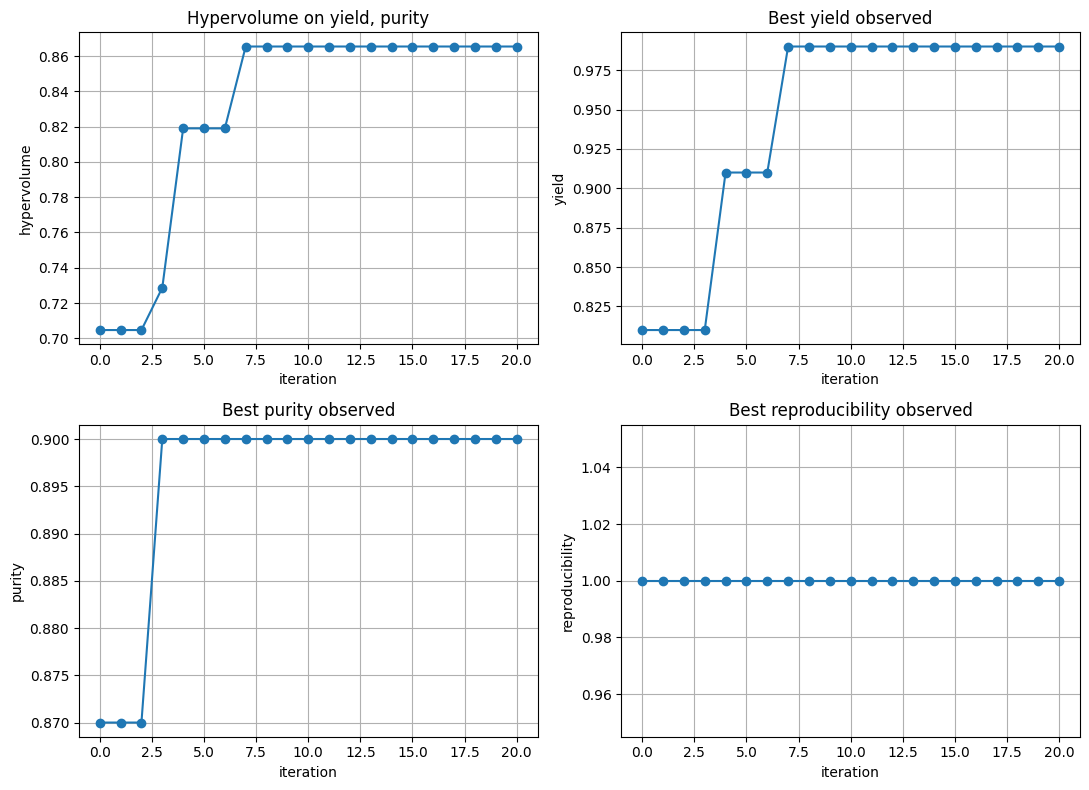

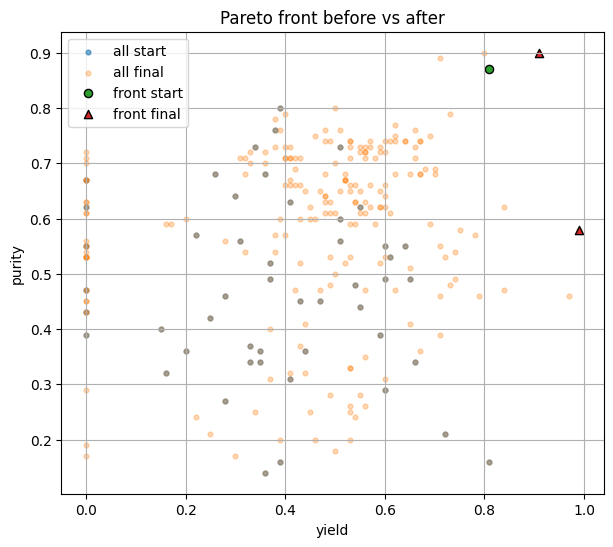

In [21]:
# ---------------------------
# 8) Four-panel progress plot + Pareto before vs after (yield, purity)
# ---------------------------

hv_trace = results["hv_trace"]
Y_hist   = results["Y_hist"]
Y_start  = results["Y_obs_start"]
Y_final  = results["Y_obs_final"]

best_y = [y[:,0].max() for y in Y_hist]
best_p = [y[:,1].max() for y in Y_hist]
best_r = [y[:,2].max() for y in Y_hist]
iters  = np.arange(len(hv_trace))

fig, axes = plt.subplots(2, 2, figsize=(11, 8))

axes[0,0].plot(iters, hv_trace, marker="o")
axes[0,0].set_title("Hypervolume on yield, purity")
axes[0,0].set_xlabel("iteration"); axes[0,0].set_ylabel("hypervolume")

axes[0,1].plot(iters, best_y, marker="o")
axes[0,1].set_title("Best yield observed")
axes[0,1].set_xlabel("iteration"); axes[0,1].set_ylabel("yield")

axes[1,0].plot(iters, best_p, marker="o")
axes[1,0].set_title("Best purity observed")
axes[1,0].set_xlabel("iteration"); axes[1,0].set_ylabel("purity")

axes[1,1].plot(iters, best_r, marker="o")
axes[1,1].set_title("Best reproducibility observed")
axes[1,1].set_xlabel("iteration"); axes[1,1].set_ylabel("reproducibility")

plt.tight_layout()
plt.show()

# Pareto start vs end on yield–purity
def nondominated_mask_2d(F2: np.ndarray) -> np.ndarray:
    F = np.asarray(F2)
    n = F.shape[0]
    mask = np.ones(n, dtype=bool)
    for i in range(n):
        if not mask[i]:
            continue
        dom = ((F >= F[i]).all(axis=1) & (F > F[i]).any(axis=1))
        dom[i] = False
        if np.any(dom):
            mask[i] = False
    return mask

Y2_start = Y_start[:, [0,1]]
Y2_final = Y_final[:, [0,1]]
front_start = Y2_start[nondominated_mask_2d(Y2_start)]
front_final = Y2_final[nondominated_mask_2d(Y2_final)]

plt.figure(figsize=(7,6))
plt.scatter(Y2_start[:,0], Y2_start[:,1], s=12, alpha=0.6, label="all start")
plt.scatter(Y2_final[:,0], Y2_final[:,1], s=12, alpha=0.3, label="all final")
plt.scatter(front_start[:,0], front_start[:,1], s=35, label="front start", edgecolor="k")
plt.scatter(front_final[:,0], front_final[:,1], s=35, label="front final", marker="^", edgecolor="k")
plt.xlabel("yield"); plt.ylabel("purity")
plt.title("Pareto front before vs after")
plt.legend()
plt.show()

Finally, we want to run the same MOBO loop four times per surrogate type (`GP` and `RF`), one for each acquisition: `EI`, `UCB`, `PI`, and `greedy mean`. The loop proposes only from the discrete `search_space`, gets outcomes only through `run_experiment(choice)`, and never reads targets from the dataframe. We track the **user-defined scalarized value** (fixed weights `[0.33, 0.33, 0.33]`) over iterations.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Tuple, List, Dict, Callable

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm

# ---------- Featurization (same as before, no dataframe access) ----------

def build_smiles_ohe(search_space: List[Tuple[Any,Any,Any,Any,Any]]) -> OneHotEncoder:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    ohe.fit(np.array([[c[4]] for c in search_space]))
    return ohe

def choices_to_matrix(search_space: List[Tuple[Any,Any,Any,Any,Any]],
                      idx: np.ndarray,
                      ohe: OneHotEncoder) -> np.ndarray:
    sel = [search_space[i] for i in idx]
    num = np.array([[float(c[0]), float(c[1]), float(c[2]), float(c[3])] for c in sel], dtype=float)
    smi = ohe.transform(np.array([[c[4]] for c in sel]))
    return np.hstack([num, smi])

# ---------- Scalarization helpers ----------

def scalarize(Y: np.ndarray, w: np.ndarray) -> np.ndarray:
    return (Y * w.reshape(1, -1)).sum(axis=1)

def best_scalar_so_far(Y_obs: np.ndarray, w: np.ndarray) -> float:
    return float(scalarize(Y_obs, w).max())

def best_each_so_far(Y_obs: np.ndarray) -> Tuple[float,float,float]:
    return float(Y_obs[:,0].max()), float(Y_obs[:,1].max()), float(Y_obs[:,2].max())

# ---------- Acquisition on scalarized stats ----------

def acq_scores(mu: np.ndarray, sd: np.ndarray, w: np.ndarray, kind: str, xi: float, kappa: float, y_best: float) -> np.ndarray:
    mu_g = (mu * w.reshape(1, -1)).sum(axis=1)
    var_g = ((sd**2) * (w.reshape(1, -1)**2)).sum(axis=1)
    sd_g = np.sqrt(np.maximum(var_g, 1e-12))

    if kind == "greedy":
        return mu_g
    if kind == "ucb":
        return mu_g + kappa * sd_g
    if kind == "pi":
        z = (mu_g - y_best - xi) / sd_g
        return norm.cdf(z)
    if kind == "ei":
        z = (mu_g - y_best - xi) / sd_g
        return (mu_g - y_best - xi) * norm.cdf(z) + sd_g * norm.pdf(z)
    raise ValueError("Unknown acquisition kind")

# ---------- One run returns all four traces ----------

def run_once_full_traces(search_space: List[Tuple[Any,Any,Any,Any,Any]],
                         run_experiment: Callable[[Tuple[Any,Any,Any,Any,Any]], Tuple[float,float,float]],
                         initial_idx: np.ndarray,
                         w: np.ndarray,
                         rounds: int,
                         batch: int,
                         cloud: int,
                         model_type: str,      # 'gp' or 'rf'
                         acq_kind: str,        # 'ei' | 'ucb' | 'pi' | 'greedy'
                         rng_seed: int = 0,
                         kappa: float = 1.0,
                         xi: float = 0.01) -> Dict[str, List[float]]:
    rng = np.random.default_rng(rng_seed)
    ohe = build_smiles_ohe(search_space)

    obs_idx = np.array(initial_idx, dtype=int)
    pool_idx = np.setdiff1d(np.arange(len(search_space)), obs_idx, assume_unique=False)

    # Initial oracle eval
    X_obs = choices_to_matrix(search_space, obs_idx, ohe)
    Y_obs = np.array([run_experiment(search_space[i]) for i in obs_idx], dtype=float)

    # Traces
    best_scalar = [best_scalar_so_far(Y_obs, w)]
    by, bp, br = best_each_so_far(Y_obs)
    best_y = [by]; best_p = [bp]; best_r = [br]

    for t in range(1, rounds + 1):
        scX = StandardScaler().fit(X_obs)
        Xtr = scX.transform(X_obs)

        # Surrogates
        if model_type == "gp":
            models = []
            kernel = C(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-4)
            for j in range(3):
                gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=1,
                                              random_state=100 + j + 17*t)
                gp.fit(Xtr, Y_obs[:, j])
                models.append(gp)
        elif model_type == "rf":
            models = []
            for j in range(3):
                rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features="sqrt",
                                           random_state=200 + j + 13*t, n_jobs=-1)
                rf.fit(Xtr, Y_obs[:, j])
                models.append(rf)
        else:
            raise ValueError("model_type must be 'gp' or 'rf'")

        if pool_idx.size == 0:
            # record and stop
            best_scalar.append(best_scalar_so_far(Y_obs, w))
            by, bp, br = best_each_so_far(Y_obs)
            best_y.append(by); best_p.append(bp); best_r.append(br)
            break

        # Candidate cloud from pool
        cand_abs = pool_idx if pool_idx.size <= cloud else rng.choice(pool_idx, size=cloud, replace=False)
        Xc = scX.transform(choices_to_matrix(search_space, cand_abs, ohe))

        # Predict
        MU = []; SD = []
        for j, m in enumerate(models):
            if model_type == "gp":
                mu_j, sd_j = m.predict(Xc, return_std=True)
            else:
                preds = np.stack([est.predict(Xc) for est in m.estimators_], axis=1)
                mu_j = preds.mean(axis=1)
                sd_j = preds.std(axis=1) + 1e-6
            MU.append(mu_j); SD.append(sd_j)
        MU = np.column_stack(MU)
        SD = np.column_stack(SD)

        # Acquisition
        y_best = best_scalar_so_far(Y_obs, w)
        scores = acq_scores(MU, SD, w, kind=acq_kind, xi=xi, kappa=kappa, y_best=y_best)

        # Pick and query oracle
        k = min(batch, cand_abs.size)
        pick_rel = np.argsort(-scores)[:k]
        new_abs = cand_abs[pick_rel]

        X_new = choices_to_matrix(search_space, new_abs, ohe)
        Y_new = np.array([run_experiment(search_space[i]) for i in new_abs], dtype=float)

        X_obs = np.vstack([X_obs, X_new])
        Y_obs = np.vstack([Y_obs, Y_new])
        pool_idx = pool_idx[~np.isin(pool_idx, new_abs)]

        # Update traces
        best_scalar.append(best_scalar_so_far(Y_obs, w))
        by, bp, br = best_each_so_far(Y_obs)
        best_y.append(by); best_p.append(bp); best_r.append(br)

    return {
        "best_scalar": best_scalar,
        "best_yield": best_y,
        "best_purity": best_p,
        "best_repro": best_r
    }

# ---------- Runner and 8-panel plot ----------

def compare_rf_gp_acq_8panels(search_space: List[Tuple[Any,Any,Any,Any,Any]],
                              run_experiment: Callable[[Tuple[Any,Any,Any,Any,Any]], Tuple[float,float,float]],
                              initial_idx: np.ndarray,
                              rounds: int = 15,
                              batch: int = 10,
                              cloud: int = 6000,
                              weights: np.ndarray = np.array([0.33, 0.33, 0.33]),
                              rng_seed: int = 123,
                              kappa: float = 1.0,
                              xi: float = 0.01) -> Dict[str, Any]:
    """
    For each surrogate∈{GP, RF} and acquisition∈{EI, UCB, PI, Greedy}, run the loop
    and plot one panel per combo. Each panel shows 4 lines:
      - best yield so far
      - best purity so far
      - best reproducibility so far
      - best scalarized value so far
    """
    w = np.asarray(weights, dtype=float); w /= w.sum()
    acqs = ["ei", "ucb", "pi", "greedy"]
    surgs = ["gp", "rf"]

    traces: Dict[str, Dict[str, Dict[str, List[float]]]] = {"gp": {}, "rf": {}}
    for acq in acqs:
        for mt in surgs:
            traces[mt][acq] = run_once_full_traces(
                search_space, run_experiment, initial_idx,
                w, rounds, batch, cloud,
                model_type=mt, acq_kind=acq,
                rng_seed=rng_seed, kappa=kappa, xi=xi
            )

    # 8 panels: 2 rows (GP, RF) x 4 cols (EI, UCB, PI, Greedy)
    fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex=False, sharey=False)
    acq_titles = {"ei": "EI", "ucb": "UCB", "pi": "PI", "greedy": "Greedy mean"}
    surg_titles = {"gp": "GP", "rf": "RF"}
    
    # Define palette 
    colors = {
        "yield": "#b6d09e",          # green
        "purity": "#f5cfa8",         # peach
        "repro": "#94cee5",          # blue
        "scalar": "#e9a2a3"          # pink
    }

    for row, mt in enumerate(surgs):
        for col, acq in enumerate(acqs):
            t = traces[mt][acq]
            it = np.arange(len(t["best_scalar"]))
            ax = axes[row, col]
            ax.plot(it, t["best_yield"], marker="o", color=colors["yield"], label="best yield")
            ax.plot(it, t["best_purity"], marker="s", color=colors["purity"], label="best purity")
            ax.plot(it, t["best_repro"], marker="^", color=colors["repro"], label="best reproducibility")
            ax.plot(it, t["best_scalar"], marker="D", color=colors["scalar"], label="best scalarized")
            ax.set_title(f"{surg_titles[mt]} — {acq_titles[acq]}")
            ax.set_xlabel("iteration")
            ax.set_ylabel("value")
            ax.grid(True, alpha=0.3)
            if row == 0 and col == 0:
                ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

    return traces

```python
traces = compare_rf_gp_acq_8panels(
    search_space=search_space,
    run_experiment=run_experiment,
    initial_idx=initial_idx,   # 50 starting indices in search_space
    rounds=15,
    batch=10,
    cloud=6000,
    weights=np.array([0.33, 0.33, 0.33]),
    rng_seed=42,
    kappa=1.0,
    xi=0.01
)
```

In [23]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/lec-15-trace1.png"))

Below, we will see when we change the weights, the MOBO will pay attention to objectives with higher weights and results can be different. 

```python
traces2 = compare_rf_gp_acq_8panels(
    search_space=search_space,
    run_experiment=run_experiment,
    initial_idx=initial_idx,   # 50 starting indices in search_space
    rounds=15,
    batch=10,
    cloud=6000,
    weights=np.array([0.8, 0.15, 0.05]), #care more on reaction yield
    rng_seed=42,
    kappa=1.0,
    xi=0.01
)
```

In [24]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/lec-15-trace2.png"))

---

## 8. Glossary

```{glossary}
Pareto dominance
  Point $a$ dominates $b$ if $a$ is at least as good on all objectives and strictly better on one.

Pareto front
  The set of nondominated objective vectors. Moving along the front trades objectives.

Scalarization
  Combine multiple objectives into one with weights $w_m \ge 0$ and $\sum w_m = 1$ to apply single objective methods.

Hypervolume
  Measure of the volume dominated by the current Pareto front compared to a reference point. Larger is better.

Expected Hypervolume Improvement
  Acquisition used in multiobjective BO that prefers candidates expected to increase hypervolume.

```


## 9. In-class activity


### Q1. Build a tiny BO “coach” with an LLM 

Use an LLM (ChatGPT or Claude) as your coding buddy to create a function in Colab or a small UI that runs Bayesian Optimization (BO) on a reaction you choose. You define the variable space and the objectives, feed a few data points, and your tool suggests 3 new experiments. After you run them, you type in the results and the tool updates, ready to suggest 3 more.

What you will produce out of this activity:
A function that:
   - choose the reaction family and define the variable space
   - input your measured results
   - Output “Suggest 3” to get the next batch
   - Support “Add results” to append new data and keep going


Suggested scope
Pick one of the following case:
- Organic reaction screening
- Catalysis screening
- Liquid nanoparticle synthesis
- MOF or polymer synthesis

Keep the variable space small at first. For example:
- temperature in {25, 50, 75, 100}
- time in {1, 2, 4}
- solvent flag in {0, 1}
- catalyst choice in {A, B, C}
Your objectives can be one or more of: yield, particle size, selectivity.

Interaction rules for the BO tool
- You input 3 measured points → tool suggests 3
- You input 9 measured points → tool suggests 3
- You can append results anytime and resuggest
- Stay within your discrete grid. Suggestions must be valid choices from your space


```{admonition} Note
Hint: Below are examples of prompts you can give to an LLM to generate code.
```


**Version** A (simpler):

In [25]:
prompt = """
**Task**  
Write Python code for Google Colab that performs multi-objective Bayesian optimization for chemists using only lists and a pandas DataFrame that the user edits by hand between runs. No widgets. No external UI. The workflow is: user defines variables and objectives, enters any existing experiments in lists, runs a function to get new suggestions, updates the lists with results after running the lab work, then calls the function again.

---

### Requirements

1) **Environment and packages**
- Use only standard Colab-friendly libraries: `numpy`, `pandas`, `itertools`, `scikit-learn` GaussianProcessRegressor and kernels, and `scipy` for acquisition optimization if needed.
- Random seed support for reproducibility: a single `seed` parameter.

2) **User inputs as plain Python lists**
- Independent variables: the user defines a dict named `variables` where each key is a clean name without prefix and each value is a dict with `start`, `end`, `interval`. Example:
  python
  variables = {
      "temperature": {"start": 50, "end": 100, "interval": 10},
      "time": {"start": 1, "end": 5, "interval": 1}
  }
 
- Objectives: the user defines a list `objectives` with 1 to 3 names, assumed normalized to 0..1. Example: `objectives = ["yield", "selectivity"]`.
- Objective weights: list `objective_weights`. If 1 objective, weight is [1.0]. If multiple, user provides weights that sum to 1.0. Validate the sum equals 1.0 within a small tolerance.

3) **Internal naming scheme**
- Code must convert variable names to columns with `var_` prefix and objective names to `obj_` prefix. Example: `temperature` becomes `var_temperature`, `yield` becomes `obj_yield`.
- Add a column `iteration` to track status. Use:
  - `-1` for not tried
  - `1, 2, ...` for completed iterations
  - The next suggested set gets the next integer

4) **Space construction**
- Build the full Cartesian grid from `variables` based on start, end, interval. Validate that `(end - start)` is divisible by `interval`. Raise a clear error message if not.
- Create a DataFrame `df_space` with all `var_...` columns, empty `obj_...` columns, and `iteration` initialized to `-1`.

5) **Manual data entry by the user**
- The user maintains two Python lists of equal length that describe completed experiments:
  - `run_conditions`: list of dicts for variables. Example:
    python
    run_conditions = [
        {"temperature": 70, "time": 3},
        {"temperature": 60, "time": 4},
    ]
    
  - `run_results`: list of dicts for objectives. Example:

    python
    run_results = [
        {"yield": 0.62, "selectivity": 0.80},
        {"yield": 0.55, "selectivity": 0.83},
    ]
    
- Code must validate that lengths match and all names match defined variables and objectives.

6) **Merging runs into the master DataFrame**
- A utility function updates `df_space`:
  - Finds rows that match each `run_conditions` entry on all `var_...` columns.
  - Writes the `obj_...` values.
  - Sets `iteration` to the current completed iteration number. If no prior data, set to `1`. If prior exists, set to `max(iteration) + 1` only for new rows.
- If a run condition does not appear in `df_space`, raise a helpful error that the value is out of grid.

7) **Modeling and acquisition**
- Default model is Gaussian Process with RBF kernel and WhiteKernel noise term. Use one model per objective.
- Scale inputs to 0..1 across each variable dimension before modeling. Keep a small epsilon to avoid zero length.
- Acquisition: Expected Improvement on the **weighted scalarized objective**. Steps:
  - Fit one GP per objective on completed rows.
  - Predict mean and std for each objective across all candidate points with `iteration == -1`.
  - Compute a weighted sum of predicted means to get scalar mean. For variance, combine via a simple diagonal approximation by weighting the std terms. Document that this is an approximation.
  - Compute EI vs the best observed weighted scalar value among completed rows.
- Tie-breaking for equal scores should be stable by index order.

8) **Suggestion function**
- Provide a main function:
  python
  def suggest_experiments(variables, objectives, objective_weights, run_conditions, run_results, batch_size=3, seed=123, save_csv=False, csv_path=None):
      
      #Returns:
        #suggestions_df: DataFrame with the next set of suggested experiments (var_ columns only)
        #df_space: Updated master DataFrame with iteration values and any new writes
      #

- Behavior:
  - Build or rebuild `df_space` from `variables`.
  - Integrate `run_conditions` and `run_results` into `df_space`.
  - If there is no completed data yet, pick `batch_size` random points from `iteration == -1` as suggestions and set their `iteration` to `1`. Return suggestions.
  - Otherwise, fit GP models as above, compute EI on all `iteration == -1` rows, pick top `batch_size` rows, set their `iteration` to `max(iteration) + 1`, and return suggestions.
  - If `save_csv` is True, write `df_space` to `csv_path` if provided, otherwise to `experiment_<timestamp>.csv`.

9) **Outputs and instructions**
- Print a short summary:
  - Number of variables and total grid size
  - Number of completed runs found
  - Batch size and iteration number suggested
- Return `suggestions_df` that shows only `var_...` columns for the user to run in the lab.
- Also return the full `df_space` so the user can save or inspect it.

10) **Round trip workflow for the user**
- First call:
  - Define `variables`, `objectives`, `objective_weights`.
  - Set `run_conditions = []` and `run_results = []` if starting fresh.
  - Call `suggest_experiments(...)` to get initial suggestions.
- After the lab:
  - Append the new completed conditions to `run_conditions` and the measured results to `run_results`.
  - Call `suggest_experiments(...)` again to receive the next suggestions.
- Provide a short example section in the notebook with a tiny space and fake results to demonstrate 2 iterations.

11) **Validation and helpful errors**
- Check weights sum to 1.0 within 1e-6.
- Check variable ranges and intervals.
- Check names match exactly.
- If no available points remain, print a clear message and return empty suggestions.

12) **No UI, no widgets, no files required**
- Everything runs in cells.
- The only persistence is optional CSV save when `save_csv=True`.

---

### Example usage block to include in the notebook

python
# 1) Define variables and objectives
variables = {
    "temperature": {"start": 50, "end": 70, "interval": 10},
    "time": {"start": 1, "end": 3, "interval": 1},
}
objectives = ["yield", "selectivity"]
objective_weights = [0.6, 0.4]  # sums to 1.0

# 2) Start with no completed data
run_conditions = []
run_results = []

# 3) First call: random suggestions
suggestions, df_space = suggest_experiments(
    variables, objectives, objective_weights,
    run_conditions, run_results,
    batch_size=2, seed=42, save_csv=False
)
print("Suggested experiments:")
print(suggestions)

# 4) Pretend we ran them in the lab, now enter results
# Convert suggested rows back to plain dicts with original names
run_conditions.extend([
    {"temperature": int(row["var_temperature"]), "time": int(row["var_time"])}
    for _, row in suggestions.iterrows()
])
run_results.extend([
    {"yield": 0.55, "selectivity": 0.78},
    {"yield": 0.61, "selectivity": 0.74},
])

# 5) Second call: model-based suggestions
suggestions, df_space = suggest_experiments(
    variables, objectives, objective_weights,
    run_conditions, run_results,
    batch_size=2, seed=42, save_csv=False
)
print("Next suggestions:")
print(suggestions)


Include all functions and imports needed to run this end to end in a fresh Colab session.
"""

LLM output code from **Version A** prompt:

In [26]:
# --- Imports
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
from typing import List, Dict, Tuple
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import norm

# --- Utility: validation

def _validate_variables(variables: Dict[str, Dict[str, float]]):
    if not isinstance(variables, dict) or len(variables) == 0:
        raise ValueError("`variables` must be a non-empty dict of {name: {start, end, interval}}.")
    for k, v in variables.items():
        if not isinstance(v, dict):
            raise ValueError(f"Variable '{k}' must map to a dict with keys start, end, interval.")
        for key in ["start", "end", "interval"]:
            if key not in v:
                raise ValueError(f"Variable '{k}' missing key '{key}'.")
        start, end, interval = v["start"], v["end"], v["interval"]
        if interval <= 0:
            raise ValueError(f"Variable '{k}' has non-positive interval.")
        diff = end - start
        # allow ints or floats that divide cleanly
        if abs((diff / interval) - round(diff / interval)) > 1e-9:
            raise ValueError(
                f"Variable '{k}' has (end - start) not divisible by interval. "
                f"Got start={start}, end={end}, interval={interval}."
            )

def _validate_objectives_and_weights(objectives: List[str], objective_weights: List[float]):
    if not isinstance(objectives, list) or len(objectives) == 0 or len(objectives) > 3:
        raise ValueError("`objectives` must be a list with 1 to 3 names.")
    if not isinstance(objective_weights, list) or len(objective_weights) != len(objectives):
        raise ValueError("`objective_weights` must be a list the same length as `objectives`.")
    wsum = float(np.sum(objective_weights))
    if abs(wsum - 1.0) > 1e-6:
        raise ValueError(f"`objective_weights` must sum to 1.0 within 1e-6. Got {wsum}.")

def _validate_run_lists(run_conditions: List[Dict], run_results: List[Dict]):
    if not isinstance(run_conditions, list) or not isinstance(run_results, list):
        raise ValueError("`run_conditions` and `run_results` must be lists.")
    if len(run_conditions) != len(run_results):
        raise ValueError("`run_conditions` and `run_results` must have equal length.")

# --- Space construction

def _build_space_df(variables: Dict[str, Dict[str, float]], objectives: List[str]) -> pd.DataFrame:
    _validate_variables(variables)
    var_names = list(variables.keys())

    # Build per-variable discrete grids
    grids = []
    for name in var_names:
        start = variables[name]["start"]
        end = variables[name]["end"]
        interval = variables[name]["interval"]
        # inclusive end
        n_steps = int(round((end - start) / interval)) + 1
        grid = [start + i * interval for i in range(n_steps)]
        grids.append(grid)

    # Cartesian product
    all_rows = list(product(*grids))
    df = pd.DataFrame(all_rows, columns=[f"var_{n}" for n in var_names])

    # Add empty objective columns
    for obj in objectives:
        df[f"obj_{obj}"] = np.nan

    # Iteration status
    df["iteration"] = -1
    return df

# --- Merge completed runs

def _merge_runs_into_space(
    df_space: pd.DataFrame,
    variables: Dict[str, Dict[str, float]],
    objectives: List[str],
    run_conditions: List[Dict],
    run_results: List[Dict],
) -> Tuple[pd.DataFrame, int]:
    """
    Writes completed runs into df_space.
    Returns updated df_space and max_completed_iteration.
    """
    _validate_run_lists(run_conditions, run_results)
    var_names = list(variables.keys())
    obj_names = list(objectives)

    # Validate names in runs
    for i, rc in enumerate(run_conditions):
        if set(rc.keys()) != set(var_names):
            raise ValueError(
                f"run_conditions[{i}] keys must match variables exactly: {var_names}. "
                f"Got {sorted(rc.keys())}."
            )
    for i, rr in enumerate(run_results):
        if set(rr.keys()) != set(obj_names):
            raise ValueError(
                f"run_results[{i}] keys must match objectives exactly: {obj_names}. "
                f"Got {sorted(rr.keys())}."
            )

    if len(run_conditions) == 0:
        return df_space, 0

    # Assign iteration numbers to completed rows in order of provided runs
    next_it = 1
    matched_any = False
    # Track which rows were already written in this pass to avoid double-assigning
    # if the same condition appears twice. Last one wins for objectives, but iteration
    # will follow the order provided.
    for idx_pair, (rc, rr) in enumerate(zip(run_conditions, run_results), start=1):
        # Build a boolean mask that matches all var_ columns
        mask = np.ones(len(df_space), dtype=bool)
        for vname, vval in rc.items():
            mask &= (df_space[f"var_{vname}"] == vval)
        matches = df_space[mask]
        if len(matches) == 0:
            raise ValueError(
                f"run_conditions[{idx_pair-1}] does not match any grid row. "
                f"At least one value is outside the defined grid."
            )

        # If multiple identical rows exist, use the first by index to keep stability
        tgt_idx = matches.index[0]
        matched_any = True

        # Write objectives
        for oname, oval in rr.items():
            df_space.loc[tgt_idx, f"obj_{oname}"] = float(oval)

        # Set iteration number in sequential order of provided runs
        df_space.loc[tgt_idx, "iteration"] = next_it
        next_it += 1

    max_completed_it = int(df_space["iteration"].clip(lower=0).max()) if matched_any else 0
    return df_space, max_completed_it

# --- Scaling to [0, 1]

def _scale_X(df_rows: pd.DataFrame, variables: Dict[str, Dict[str, float]]) -> np.ndarray:
    var_names = list(variables.keys())
    X = df_rows[[f"var_{v}" for v in var_names]].to_numpy(dtype=float)
    mins = np.array([variables[v]["start"] for v in var_names], dtype=float)
    maxs = np.array([variables[v]["end"] for v in var_names], dtype=float)
    span = maxs - mins
    eps = 1e-12
    span = np.where(span < eps, eps, span)
    X_scaled = (X - mins) / span
    X_scaled = np.clip(X_scaled, 0.0, 1.0)
    return X_scaled

# --- GP fitting and EI

def _fit_gp_models(
    X_train: np.ndarray,
    Y_list: List[np.ndarray],
    seed: int,
) -> List[GaussianProcessRegressor]:
    models = []
    for y in Y_list:
        # Drop NaNs if any are present
        mask = ~np.isnan(y)
        if mask.sum() < 1:
            # No data for this objective
            models.append(None)
            continue
        Xt = X_train[mask]
        yt = y[mask]
        kernel = RBF(length_scale=np.ones(X_train.shape[1])) + WhiteKernel(noise_level=1e-6)
        gp = GaussianProcessRegressor(
            kernel=kernel,
            alpha=0.0,            # use WhiteKernel for noise
            normalize_y=True,
            random_state=seed,
            n_restarts_optimizer=1
        )
        gp.fit(Xt, yt)
        models.append(gp)
    return models

def _predict_objectives(models: List[GaussianProcessRegressor], X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    #Returns:
      #means: shape (n_points, n_obj)
      #stds:  shape (n_points, n_obj)
    
    n_points = X.shape[0]
    n_obj = len(models)
    means = np.full((n_points, n_obj), np.nan, dtype=float)
    stds = np.full((n_points, n_obj), np.nan, dtype=float)
    for j, gp in enumerate(models):
        if gp is None:
            continue
        m, s = gp.predict(X, return_std=True)
        means[:, j] = m
        stds[:, j] = s
    return means, stds

def _weighted_scalarization(means: np.ndarray, stds: np.ndarray, weights: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simple diagonal approximation for variance:
      mu_s = sum_j w_j * mu_j
      sigma_s = sqrt(sum_j (w_j * sigma_j)^2)
    """
    mu_s = np.nansum(means * weights[None, :], axis=1)
    sigma_s = np.sqrt(np.nansum((stds * weights[None, :]) ** 2, axis=1))
    return mu_s, sigma_s

def _expected_improvement(mu: np.ndarray, sigma: np.ndarray, best: float, xi: float = 0.0) -> np.ndarray:
    """
    EI against best observed scalar value.
    """
    imp = mu - best - xi
    with np.errstate(divide="ignore", invalid="ignore"):
        Z = np.where(sigma > 0, imp / sigma, 0.0)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei = np.where(sigma <= 0, 0.0, ei)
    # Negative EI not useful
    ei = np.maximum(ei, 0.0)
    return ei

# --- Main API

def suggest_experiments(
    variables: Dict[str, Dict[str, float]],
    objectives: List[str],
    objective_weights: List[float],
    run_conditions: List[Dict],
    run_results: List[Dict],
    batch_size: int = 3,
    seed: int = 123,
    save_csv: bool = False,
    csv_path: str = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    #
    #Returns:
      #suggestions_df: DataFrame of suggested experiments (var_ columns only)
      #df_space: full updated DataFrame
    #
    rng = np.random.default_rng(seed)
    _validate_objectives_and_weights(objectives, objective_weights)

    # Build space fresh each call
    df_space = _build_space_df(variables, objectives)

    # Merge completed runs
    df_space, max_completed_iteration = _merge_runs_into_space(
        df_space, variables, objectives, run_conditions, run_results
    )

    # Summary numbers
    var_cols = [c for c in df_space.columns if c.startswith("var_")]
    obj_cols = [f"obj_{o}" for o in objectives]
    grid_size = len(df_space)
    n_vars = len(var_cols)

    # Completed rows have iteration > 0 and no NaNs in objectives
    completed_mask = (df_space["iteration"] > 0)
    for oc in obj_cols:
        completed_mask &= ~df_space[oc].isna()
    n_completed = int(completed_mask.sum())

    # Candidates are rows not yet tried
    cand_mask = df_space["iteration"] == -1
    n_candidates = int(cand_mask.sum())

    if n_candidates == 0:
        print(f"No available points remain. Grid size {grid_size}. Completed runs {n_completed}.")
        return pd.DataFrame(columns=var_cols), df_space

    # If no completed data yet, return random suggestions
    if n_completed == 0:
        choose_k = min(batch_size, n_candidates)
        cand_indices = df_space.index[cand_mask].to_numpy()
        rng.shuffle(cand_indices)
        chosen = cand_indices[:choose_k]
        # Assign iteration numbers to suggested rows
        next_it = 1  # first iteration of the campaign
        for idx in chosen:
            df_space.loc[idx, "iteration"] = next_it
        suggestions_df = df_space.loc[chosen, var_cols].reset_index(drop=True)

        print(f"Variables: {n_vars}, grid size: {grid_size}")
        print(f"Completed runs found: {n_completed}")
        print(f"Suggesting batch of {choose_k} for iteration {next_it}")
        if save_csv:
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            out = csv_path if csv_path else f"experiment_{ts}.csv"
            df_space.to_csv(out, index=False)
            print(f"Saved df_space to: {out}")
        return suggestions_df, df_space

    # Model-based suggestions
    # Prepare training and candidate matrices in [0, 1]
    X_train = _scale_X(df_space.loc[completed_mask, var_cols], variables)
    Y_list = [df_space.loc[completed_mask, f"obj_{o}"].to_numpy(dtype=float) for o in objectives]
    models = _fit_gp_models(X_train, Y_list, seed=seed)

    # Predict on candidates
    X_cand = _scale_X(df_space.loc[cand_mask, var_cols], variables)
    means, stds = _predict_objectives(models, X_cand)

    # Weighted scalarization of predictive distribution
    w = np.array(objective_weights, dtype=float)
    mu_s, sigma_s = _weighted_scalarization(means, stds, w)

    # Best observed weighted scalar on completed data
    completed_means = np.vstack([df_space.loc[completed_mask, f"obj_{o}"].to_numpy(dtype=float) for o in objectives]).T
    best_scalar = float((completed_means * w[None, :]).sum(axis=1).max())

    # EI on candidates
    ei = _expected_improvement(mu_s, sigma_s, best_scalar, xi=0.0)

    # Stable tie-breaking by original index order
    cand_idx = df_space.index[cand_mask].to_numpy()
    order = np.lexsort((-ei, cand_idx))  # sort by EI desc, then index asc
    chosen = cand_idx[order][:min(batch_size, len(cand_idx))]

    # Assign next iteration number to suggestions
    next_it = int(max_completed_iteration) + 1 if max_completed_iteration > 0 else 1
    for idx in chosen:
        df_space.loc[idx, "iteration"] = next_it

    suggestions_df = df_space.loc[chosen, var_cols].reset_index(drop=True)

    print(f"Variables: {n_vars}, grid size: {grid_size}")
    print(f"Completed runs found: {n_completed}")
    print(f"Suggesting batch of {len(chosen)} for iteration {next_it}")

    if save_csv:
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        out = csv_path if csv_path else f"experiment_{ts}.csv"
        df_space.to_csv(out, index=False)
        print(f"Saved df_space to: {out}")

    return suggestions_df, df_space

##############################################################################

  ###EXAMPLE USE#####  
# 1) Define variables and objectives
variables = {
    "temperature": {"start": 50, "end": 70, "interval": 10},
    "time": {"start": 1, "end": 3, "interval": 1},
}
objectives = ["yield", "selectivity"]
objective_weights = [0.6, 0.4]  # sums to 1.0

# 2) Start with no completed data
run_conditions = []
run_results = []

# 3) First call: random suggestions
suggestions, df_space = suggest_experiments(
    variables, objectives, objective_weights,
    run_conditions, run_results,
    batch_size=2, seed=42, save_csv=False
)
print("Suggested experiments:")
print(suggestions)


# 4) Pretend we ran them in the lab, now enter results
# Convert suggested rows back to plain dicts with original names
run_conditions.extend([
    {"temperature": int(row["var_temperature"]), "time": int(row["var_time"])}
    for _, row in suggestions.iterrows()
])
run_results.extend([
    {"yield": 0.55, "selectivity": 0.78},
    {"yield": 0.61, "selectivity": 0.74},
])

# 5) Second call: model-based suggestions
suggestions, df_space = suggest_experiments(
    variables, objectives, objective_weights,
    run_conditions, run_results,
    batch_size=2, seed=42, save_csv=False
)
print("Next suggestions:")
print(suggestions)


# THEN you can do third call.....

Variables: 2, grid size: 9
Completed runs found: 0
Suggesting batch of 2 for iteration 1
Suggested experiments:
   var_temperature  var_time
0               60         1
1               50         1
Variables: 2, grid size: 9
Completed runs found: 2
Suggesting batch of 2 for iteration 3
Next suggestions:
   var_temperature  var_time
0               50         2
1               50         3


Now we can also consider **Version B** (more features), with UI and bottons for someone who does not code in your lab to use:

In [27]:

promptB = """

**Task:**  
In Google Colab, write Python code that creates a **popup-style interactive UI** for *multi-objective Bayesian optimization* for chemists. The tool should guide users through setting up or continuing an optimization experiment with intuitive inputs and automated CSV handling.

---

### **General Requirements**
- Use **Google Colab UI elements** (`ipywidgets` or `gradio` if suitable) to create a popup-style or form-based interface.  
- Ensure all UI components are clearly labeled and organized in steps.  
- Include inline validation (e.g., weight sum equals 1, valid numeric intervals).  
- Save and read CSV files locally in the Colab environment.  
- Code must be modular, with functions for UI rendering, CSV generation, data validation, and Bayesian suggestion updates.

---

### **Step 1: Start Screen**
When the notebook runs, display a popup or landing panel with **two mode buttons**:
1. **Establish New Experiment**
2. **Start from Existing Experiment**

Each button triggers a separate workflow.

---

### **Step 2: Establish New Experiment Workflow**
When the user clicks **"Establish New Experiment"**, do the following:

#### **2.1 Variable Definition**
- Ask for **at least one independent variable** (e.g., temperature, pressure).  
  Each variable requires:
  - Name input field (e.g., “Temperature”)  
  - Numeric start value  
  - Numeric end value  
  - Interval value  
- Provide a **“+ Add another variable”** button to add more variables dynamically.
- Each variable name should automatically be prefixed as `var_<name>` in the output (e.g., `var_temperature`).

#### **2.2 Objective Definition**
- Ask for **1 to 3 objective variables** (e.g., yield, selectivity).
- Each objective name will be automatically prefixed as `obj_<name>`.
- All objectives are **assumed to be normalized (0–1)** values.
- If more than one objective is defined:
  - Ask the user to assign **weights** to each.
  - Validate that all weights sum to **1.0**.
- If only one objective is defined, it automatically receives a weight of **1.0**.

#### **2.3 Space and Experiment Setup**
Ask for the following:
- **Total number of reaction space points** (the total grid size generated from variable intervals).
- **Number of experiments to run at a time** (default = 3).
- **Whether existing experimental data is available** (Yes/No radio buttons).

#### **2.4 Handling Existing Data**
- If **Yes**:
  - Display a small data entry form (or file upload option) where the user can enter or upload:
    - Columns matching variable names (`var_...`)
    - Objective values (`obj_...`)
  - These entries are assigned **iteration = 1** in the CSV (indicating completed experiments).
- If **No**:
  - Perform **random sampling** to suggest the first N (default 3) experiments.
  - Assign these as **iteration = 1** (indicating suggested experiments).

#### **2.5 CSV Generation**
- Automatically generate a **CSV file** with the following:
  - Columns:
    - All `var_...` variables
    - All `obj_...` objectives (blank for suggested experiments)
    - `iteration` column (integer values)
  - Initially fill:
    - All possible variable combinations (full space)
    - Objective columns as blank
    - `iteration` = -1 for untested combinations
    - Suggested experiment rows marked with the **largest iteration number**
- Save the CSV file locally with a user-defined or auto-generated name (`experiment_<timestamp>.csv`).

#### **2.6 Default Algorithm**
- Default optimization algorithm: **Gaussian Process (GP)** with **Expected Improvement (EI)**.
- Display a summary of suggested experiments to the user before saving.

---

### **Step 3: Start from Existing Experiment Workflow**
When the user clicks **“Start from Existing Experiment”**:
- Prompt them to **upload or select an existing local CSV file**.

#### **3.1 CSV Parsing**
After upload:
- Automatically scan the CSV:
  - Identify variable columns (`var_...`)
  - Identify objective columns (`obj_...`)
  - Identify iteration column
- Verify:
  - At least one `obj_...` column exists.
  - The **largest iteration number** corresponds to completed experiments.
  - If objective values for the latest iteration are missing, display a **reminder** to fill them before proceeding.

#### **3.2 Next Suggestion Generation**
- Once validated:
  - Fit the **Bayesian model** using completed experiment data.
  - Suggest the next N experiments (using the same number as before unless the user specifies otherwise).
  - Append the new suggestions to the CSV file.
  - Assign these new rows **iteration = (max_iteration + 1)**.
  - Display the suggested experiments for user review.

---

### **Step 4: Additional Functional Features**
- **Validation Checks:**
  - Numeric range consistency (start < end).
  - Interval divides the range evenly.
  - Objective weight sum = 1.0.
  - Variable and objective names cannot repeat.
- **UI Elements:**
  - Progress indicators between steps.
  - Clear success messages after saving CSV.
  - Option to reopen the main menu without rerunning the cell.

---

### **Step 5: Data Handling Notes**
- All CSV files should include:
  
  var_xxx | var_yyy | ... | obj_aaa | obj_bbb | iteration
  
- Default “unrun” rows → `iteration = -1`.
- Suggested (pending) experiments → next iteration number.
- Completed experiments → filled objective values.

---

### **Step 6: Suggested Extensions (Optional)**
You may include:
- Plotting functions (2D or 3D scatter for objectives and variables).  
- Export results to Excel.  
- Log system to track runs and timestamps.  
- Optional parameter for random seed for reproducibility.

"""

LLM output code from **Version B** prompt:

In [28]:
import io
import itertools
import math
import os
import time
from datetime import datetime
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

from IPython.display import display, clear_output
import ipywidgets as w

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C


# =========================
# Helpers: validation
# =========================

def _is_float(x) -> bool:
    try:
        float(x)
        return True
    except Exception:
        return False

def validate_variables(var_rows: List[Dict]) -> Tuple[bool, str]:
    seen = set()
    for i, row in enumerate(var_rows, 1):
        name = row["name"].strip()
        if not name:
            return False, f"Variable {i}: name required"
        if name.lower() in seen:
            return False, f"Variable {i}: duplicate name '{name}'"
        seen.add(name.lower())

        if not (_is_float(row["start"]) and _is_float(row["end"]) and _is_float(row["step"])):
            return False, f"Variable {name}: start, end, and interval must be numeric"

        start = float(row["start"])
        end = float(row["end"])
        step = float(row["step"])

        if not start < end:
            return False, f"Variable {name}: start must be less than end"
        if step <= 0:
            return False, f"Variable {name}: interval must be positive"

        span = end - start
        k = span / step
        if abs(round(k) - k) > 1e-8:
            return False, f"Variable {name}: interval does not divide range evenly. Choose step so (end - start)/step is an integer"
    return True, ""

def validate_objectives(obj_rows: List[Dict]) -> Tuple[bool, str, np.ndarray]:
    if not obj_rows:
        return False, "At least one objective required", np.array([])
    if len(obj_rows) > 3:
        return False, "Maximum 3 objectives", np.array([])
    seen = set()
    for i, row in enumerate(obj_rows, 1):
        name = row["name"].strip()
        if not name:
            return False, f"Objective {i}: name required", np.array([])
        if name.lower() in seen:
            return False, f"Objective {i}: duplicate name '{name}'", np.array([])
        seen.add(name.lower())
    # weights
    if len(obj_rows) == 1:
        weights = np.array([1.0], dtype=float)
        return True, "", weights

    weights = []
    for row in obj_rows:
        wv = row["weight"]
        if not _is_float(wv):
            return False, f"Weight for objective '{row['name']}' must be numeric", np.array([])
        weights.append(float(wv))
    weights = np.array(weights, dtype=float)
    s = weights.sum()
    if not np.isfinite(s):
        return False, "Weights must be finite numbers", np.array([])
    if abs(s - 1.0) > 1e-6:
        return False, f"Weight sum must be 1.0. Current sum = {s:.6f}", np.array([])
    if np.any(weights < 0):
        return False, "Weights must be nonnegative", np.array([])
    return True, "", weights

def validate_grid_size(var_rows: List[Dict], claimed_total: int) -> Tuple[bool, str, int]:
    sizes = []
    for row in var_rows:
        start = float(row["start"])
        end = float(row["end"])
        step = float(row["step"])
        n = int(round((end - start) / step)) + 1
        sizes.append(n)
    total = int(np.prod(sizes)) if sizes else 0
    if claimed_total is not None and claimed_total > 0 and claimed_total != total:
        return False, f"Computed grid size is {total} but you entered {claimed_total}", total
    return True, "", total


# =========================
# Helpers: space, CSV, IO
# =========================

def make_grid_dataframe(var_rows: List[Dict]) -> pd.DataFrame:
    grids = []
    col_names = []
    for row in var_rows:
        start = float(row["start"])
        end = float(row["end"])
        step = float(row["step"])
        n = int(round((end - start) / step)) + 1
        vals = [start + i * step for i in range(n)]
        col = f"var_{row['name'].strip().lower()}"
        col_names.append(col)
        grids.append(vals)

    if not grids:
        return pd.DataFrame()

    all_points = list(itertools.product(*grids))
    df = pd.DataFrame(all_points, columns=col_names)
    return df

def add_objective_columns(df: pd.DataFrame, obj_rows: List[Dict]) -> List[str]:
    obj_cols = []
    for row in obj_rows:
        col = f"obj_{row['name'].strip().lower()}"
        obj_cols.append(col)
        if col not in df.columns:
            df[col] = np.nan
    if "iteration" not in df.columns:
        df["iteration"] = -1
    return obj_cols

def save_experiment_csv(df: pd.DataFrame, filename: Optional[str] = None) -> str:
    if filename is None or not filename.strip():
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"experiment_{ts}.csv"
    df.to_csv(filename, index=False)
    return filename

def parse_uploaded_csv(content: bytes) -> pd.DataFrame:
    return pd.read_csv(io.BytesIO(content))

def detect_columns(df: pd.DataFrame) -> Tuple[List[str], List[str], str]:
    var_cols = [c for c in df.columns if c.startswith("var_")]
    obj_cols = [c for c in df.columns if c.startswith("obj_")]
    it_col = "iteration" if "iteration" in df.columns else None
    return var_cols, obj_cols, it_col


# =========================
# Bayesian Suggestion (GP + EI)
# =========================

def fit_gp_ei_scorer(X_obs: np.ndarray, y_obs: np.ndarray):
    # Kernel: C * Matern + White
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(X_obs.shape[1]), length_scale_bounds=(1e-2, 1e3), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e-1))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=3, normalize_y=True, random_state=0)
    gp.fit(X_obs, y_obs)

    best_y = np.max(y_obs)

    def ei(X_cand: np.ndarray) -> np.ndarray:
        mu, std = gp.predict(X_cand, return_std=True)
        std = np.clip(std, 1e-12, None)
        Z = (mu - best_y) / std
        from scipy.stats import norm
        ei_vals = (mu - best_y) * norm.cdf(Z) + std * norm.pdf(Z)
        ei_vals[std < 1e-12] = 0.0
        return ei_vals

    return ei

def suggest_next(df: pd.DataFrame,
                 var_cols: List[str],
                 obj_cols: List[str],
                 n_suggest: int,
                 weights: np.ndarray,
                 random_seed: Optional[int] = None) -> pd.DataFrame:
    rng = np.random.default_rng(random_seed)
    # Completed rows have all obj columns filled
    completed_mask = df[obj_cols].notna().all(axis=1)
    untested_mask = df["iteration"] == -1

    # If no completed data, pick random untested
    if completed_mask.sum() == 0:
        cand_idx = np.where(untested_mask)[0]
        if len(cand_idx) == 0:
            return pd.DataFrame(columns=df.columns)
        pick = rng.choice(cand_idx, size=min(n_suggest, len(cand_idx)), replace=False)
        return df.iloc[pick]

    # Weighted sum objective (objectives assumed normalized 0..1)
    Y = df.loc[completed_mask, obj_cols].values.astype(float)
    y_obs = (Y * weights).sum(axis=1)
    X_obs = df.loc[completed_mask, var_cols].values.astype(float)

    # Candidates are untested rows
    X_cand_df = df.loc[untested_mask, var_cols]
    if X_cand_df.empty:
        return pd.DataFrame(columns=df.columns)

    # Fit GP and rank by EI
    try:
        scorer = fit_gp_ei_scorer(X_obs, y_obs)
        ei_vals = scorer(X_cand_df.values.astype(float))
        order = np.argsort(-ei_vals)
        top_idx = X_cand_df.index.values[order[:min(n_suggest, len(order))]]
        return df.loc[top_idx]
    except Exception:
        # Fallback to random if GP fails
        cand_idx = X_cand_df.index.values
        rng.shuffle(cand_idx)
        return df.loc[cand_idx[:min(n_suggest, len(cand_idx))]]


# =========================
# UI components
# =========================

class ChemBOUI:
    def __init__(self):
        self.main_box = w.VBox()
        self._build_start_screen()
        display(self.main_box)

    def _build_start_screen(self):
        title = w.HTML("<h2>Multi-objective Bayesian Optimization</h2>")
        desc = w.HTML("Choose a mode to begin")
        new_btn = w.Button(description="Establish New Experiment", button_style="primary", icon="plus")
        exist_btn = w.Button(description="Start from Existing Experiment", button_style="", icon="upload")

        new_btn.on_click(lambda _: self._new_experiment_flow())
        exist_btn.on_click(lambda _: self._existing_experiment_flow())
        self.main_menu = w.VBox([title, desc, w.HBox([new_btn, exist_btn])])
        self._set_content(self.main_menu)

    def _set_content(self, widget):
        self.main_box.children = [widget]

    def _back_to_menu(self, *_):
        self._set_content(self.main_menu)

    # ---------- New experiment workflow ----------

    def _new_experiment_flow(self):
        # Step containers
        self.var_rows_ui = []   # each: dict of widgets for a variable row
        self.obj_rows_ui = []   # each: dict of widgets for an objective row
        self.existing_entries = []  # manual data entry rows

        # Step 2.1 Variables
        hdr1 = w.HTML("<h3>Step 1 of 4: Define variables</h3>")
        self.var_box = w.VBox([])
        add_var_btn = w.Button(description="+ Add another variable", icon="plus")
        add_var_btn.on_click(lambda _: self._add_variable_row())

        # Add initial variable row
        self._add_variable_row()

        # Step 2.2 Objectives
        hdr2 = w.HTML("<h3>Step 2 of 4: Define objectives</h3>")
        self.obj_box = w.VBox([])
        add_obj_btn = w.Button(description="+ Add objective", icon="plus")
        add_obj_btn.on_click(lambda _: self._add_objective_row())
        # Add first objective row by default
        self._add_objective_row()

        # Step 2.3 Space and experiment setup
        hdr3 = w.HTML("<h3>Step 3 of 4: Space and experiment setup</h3>")
        self.total_points_in = w.BoundedIntText(value=0, min=0, description="Total grid points (check)", layout=w.Layout(width="360px"))
        self.batch_in = w.BoundedIntText(value=3, min=1, description="Experiments per batch", layout=w.Layout(width="360px"))
        self.use_existing_radio = w.RadioButtons(options=["No", "Yes"], description="Existing data available?")
        self.seed_in = w.BoundedIntText(value=0, min=0, description="Random seed (optional)", layout=w.Layout(width="360px"))
        self.filename_in = w.Text(value="", placeholder="experiment_<timestamp>.csv", description="CSV name", layout=w.Layout(width="420px"))

        # Step 2.4 Existing data entry or upload
        hdr4 = w.HTML("<h3>Step 4 of 4: Existing data (optional)</h3>")
        self.upload_widget = w.FileUpload(accept=".csv", multiple=False)
        self.manual_add_button = w.Button(description="+ Add one completed row manually", icon="edit")
        self.manual_rows_box = w.VBox([])

        self.use_existing_radio.observe(self._toggle_existing_data_ui, names="value")
        self.manual_add_button.on_click(self._add_manual_completed_row)

        # Progress and actions
        self.progress = w.IntProgress(value=0, min=0, max=4)
        self.status = w.HTML("")
        self.next_btn = w.Button(description="Generate CSV and suggestions", button_style="success", icon="cogs")
        self.next_btn.on_click(self._finalize_new_experiment)
        self.back_btn = w.Button(description="Back to main menu", icon="home")
        self.back_btn.on_click(self._back_to_menu)

        container = w.VBox([
            hdr1, self.var_box, add_var_btn,
            w.HTML("<hr>"),
            hdr2, self.obj_box, add_obj_btn,
            w.HTML("<hr>"),
            hdr3, w.HBox([self.total_points_in, self.batch_in]), w.HBox([self.use_existing_radio, self.seed_in]), self.filename_in,
            w.HTML("<hr>"),
            hdr4,
            w.HTML("Upload a CSV that matches the variable and objective columns OR add one or more completed rows manually"),
            w.HBox([w.VBox([w.HTML("<b>Upload CSV</b>"), self.upload_widget]),
                    w.VBox([w.HTML("<b>Manual entry</b>"), self.manual_add_button, self.manual_rows_box])] ),
            w.HTML("<hr>"),
            self.progress, self.status,
            w.HBox([self.next_btn, self.back_btn])
        ])
        self._set_content(container)
        self._toggle_existing_data_ui()

    def _add_variable_row(self):
        name = w.Text(placeholder="e.g., temperature", description="Name", layout=w.Layout(width="280px"))
        start = w.FloatText(value=0.0, description="Start", layout=w.Layout(width="200px"))
        end = w.FloatText(value=1.0, description="End", layout=w.Layout(width="200px"))
        step = w.FloatText(value=0.1, description="Interval", layout=w.Layout(width="200px"))
        rm = w.Button(description="Remove", icon="trash", layout=w.Layout(width="120px"))
        row_widgets = dict(name=name, start=start, end=end, step=step, rm=rm)
        box = w.HBox([name, start, end, step, rm])

        def _rm(_):
            self.var_rows_ui.remove(row_widgets)
            self.var_box.children = [w.HBox([r["name"], r["start"], r["end"], r["step"], r["rm"]]) for r in self.var_rows_ui]

        rm.on_click(_rm)
        self.var_rows_ui.append(row_widgets)
        self.var_box.children = [w.HBox([r["name"], r["start"], r["end"], r["step"], r["rm"]]) for r in self.var_rows_ui]

    def _add_objective_row(self):
        name = w.Text(placeholder="e.g., yield", description="Name", layout=w.Layout(width="280px"))
        weight = w.FloatText(value=np.nan, description="Weight", layout=w.Layout(width="200px"))
        rm = w.Button(description="Remove", icon="trash", layout=w.Layout(width="120px"))

        row_widgets = dict(name=name, weight=weight, rm=rm)
        if len(self.obj_rows_ui) == 0:
            weight.value = 1.0  # first objective default if only one
        box = w.HBox([name, weight, rm])

        def _rm(_):
            self.obj_rows_ui.remove(row_widgets)
            self.obj_box.children = [w.HBox([r["name"], r["weight"], r["rm"]]) for r in self.obj_rows_ui]

        rm.on_click(_rm)
        self.obj_rows_ui.append(row_widgets)
        self.obj_box.children = [w.HBox([r["name"], r["weight"], r["rm"]]) for r in self.obj_rows_ui]

    def _toggle_existing_data_ui(self, *_):
        use_existing = self.use_existing_radio.value == "Yes"
        self.upload_widget.disabled = not use_existing
        self.manual_add_button.disabled = not use_existing
        for child in self.manual_rows_box.children:
            child.layout.display = "flex" if use_existing else "none"

    def _add_manual_completed_row(self, *_):
        if not self.var_rows_ui or not self.obj_rows_ui:
            self.status.value = "<span style='color:red'>Add variables and objectives first</span>"
            return
        # Build inputs based on current names
        var_names = [f"var_{r['name'].value.strip().lower()}" for r in self.var_rows_ui if r["name"].value.strip()]
        obj_names = [f"obj_{r['name'].value.strip().lower()}" for r in self.obj_rows_ui if r["name"].value.strip()]

        row_widgets = {}
        row_items = []
        for vn in var_names:
            row_widgets[vn] = w.FloatText(description=vn, layout=w.Layout(width="220px"))
            row_items.append(row_widgets[vn])
        for on in obj_names:
            row_widgets[on] = w.BoundedFloatText(description=on, min=0.0, max=1.0, layout=w.Layout(width="240px"))
            row_items.append(row_widgets[on])
        rm = w.Button(description="Remove row", icon="trash")
        row_widgets["rm"] = rm
        row_box = w.HBox(row_items + [rm])

        def _rm(_):
            self.existing_entries.remove(row_widgets)
            self.manual_rows_box.children = [self._manual_row_to_box(r) for r in self.existing_entries]

        rm.on_click(_rm)
        self.existing_entries.append(row_widgets)
        self.manual_rows_box.children = [self._manual_row_to_box(r) for r in self.existing_entries]

    def _manual_row_to_box(self, row_widgets: Dict) -> w.Widget:
        row_items = [row_widgets[k] for k in row_widgets if k != "rm"]
        return w.HBox(row_items + [row_widgets["rm"]])

    def _collect_vars(self) -> List[Dict]:
        rows = []
        for r in self.var_rows_ui:
            rows.append(dict(name=r["name"].value, start=r["start"].value, end=r["end"].value, step=r["step"].value))
        return rows

    def _collect_objs(self) -> List[Dict]:
        rows = []
        for r in self.obj_rows_ui:
            rows.append(dict(name=r["name"].value, weight=r["weight"].value))
        return rows

    def _finalize_new_experiment(self, *_):
        self.progress.value = 0
        self.status.value = ""

        var_rows = self._collect_vars()
        ok, msg = validate_variables(var_rows)
        if not ok:
            self.status.value = f"<span style='color:red'>{msg}</span>"
            return
        self.progress.value = 1

        obj_rows = self._collect_objs()
        ok, msg, weights = validate_objectives(obj_rows)
        if not ok:
            self.status.value = f"<span style='color:red'>{msg}</span>"
            return
        self.progress.value = 2

        # Grid and size check
        grid_df = make_grid_dataframe(var_rows)
        claimed_total = int(self.total_points_in.value) if self.total_points_in.value else None
        ok, msg, total = validate_grid_size(var_rows, claimed_total if claimed_total else 0)
        if not ok:
            self.status.value = f"<span style='color:orange'>{msg}. You can correct the input or leave Total grid points at 0 to accept {total}</span>"
            return
        if claimed_total in (None, 0):
            self.total_points_in.value = total

        # Add objectives and iteration
        obj_cols = add_objective_columns(grid_df, obj_rows)
        var_cols = [c for c in grid_df.columns if c.startswith("var_")]
        grid_df["iteration"] = -1

        n_batch = int(self.batch_in.value)
        seed = int(self.seed_in.value) if self.seed_in.value else None

        # Load existing completed data if provided
        completed_df = pd.DataFrame(columns=grid_df.columns)
        if self.use_existing_radio.value == "Yes":
            # Uploaded CSV
            if len(self.upload_widget.value):
                up = next(iter(self.upload_widget.value.values()))
                try:
                    df_up = parse_uploaded_csv(up["content"])
                    up_var_cols, up_obj_cols, it_col = detect_columns(df_up)
                    # Basic column presence check
                    missing_vars = [c for c in var_cols if c not in df_up.columns]
                    missing_objs = [c for c in obj_cols if c not in df_up.columns]
                    if missing_vars or missing_objs or it_col is None:
                        self.status.value = "<span style='color:red'>Uploaded CSV must include matching var_*, obj_* columns and an iteration column</span>"
                        return
                    completed_rows = df_up[up_obj_cols].notna().all(axis=1)
                    completed_df = df_up.loc[completed_rows, grid_df.columns.intersection(df_up.columns)]
                except Exception as e:
                    self.status.value = f"<span style='color:red'>Failed to parse uploaded CSV: {e}</span>"
                    return

            # Manual rows
            for row in self.existing_entries:
                rec = {c: np.nan for c in grid_df.columns}
                rec["iteration"] = 1
                try:
                    for k, v in row.items():
                        if k == "rm":
                            continue
                        rec[k] = float(v.value)
                except Exception:
                    self.status.value = "<span style='color:red'>Manual row values must be numeric</span>"
                    return
                completed_df = pd.concat([completed_df, pd.DataFrame([rec])], ignore_index=True)

            # Merge completed into grid_df where coordinates match
            if not completed_df.empty:
                # Key on all var columns
                grid_df = grid_df.merge(
                    completed_df[var_cols + obj_cols + ["iteration"]],
                    on=var_cols, how="left", suffixes=("", "_comp")
                )
                for oc in obj_cols + ["iteration"]:
                    c_new = f"{oc}_comp"
                    if c_new in grid_df.columns:
                        grid_df[oc] = np.where(grid_df[c_new].notna(), grid_df[c_new], grid_df[oc])
                        grid_df.drop(columns=[c_new], inplace=True)

        self.progress.value = 3

        # Suggest first batch
        # Mark suggested rows with iteration = 1 if none completed, else keep completed ones at their iteration and suggest next
        has_completed = grid_df[obj_cols].notna().all(axis=1).any()
        current_iter = 1
        if has_completed:
            # set current_iter as 1 + max completed iteration found in data, else 1
            if "iteration" in grid_df.columns and grid_df["iteration"].max() >= 1:
                current_iter = int(grid_df["iteration"].max()) + 1
            else:
                current_iter = 2

        # Prepare weights from objs
        if len(obj_rows) == 1:
            weights = np.array([1.0])

        suggestions = suggest_next(grid_df.copy(), var_cols, obj_cols, n_batch, weights, random_seed=seed)

        if suggestions.empty:
            self.status.value = "<span style='color:orange'>No available untested rows to suggest</span>"
        else:
            # Mark iteration for suggested rows
            sug_idx = suggestions.index
            grid_df.loc[sug_idx, "iteration"] = current_iter
            # Suggested experiments have blank objectives
            for oc in obj_cols:
                grid_df.loc[sug_idx, oc] = np.nan

        # Save CSV
        filename = save_experiment_csv(grid_df, self.filename_in.value)
        self.progress.value = 4

        # Show summary
        top = suggestions[var_cols].copy()
        top["iteration"] = current_iter
        html = f"<b>Algorithm</b>: Gaussian Process with Expected Improvement<br>"
        html += f"<b>Suggested experiments (n={len(top)})</b>:"
        self.status.value = html

        out = w.Output()
        with out:
            display(top.reset_index(drop=True))
            print(f"CSV saved: {filename}")
        done = w.HTML("<span style='color:green'>Success. You can run experiments, fill objective values, then use Start from Existing Experiment to continue</span>")
        menu_btn = w.Button(description="Return to main menu", icon="home")
        menu_btn.on_click(self._back_to_menu)
        self._set_content(w.VBox([self.main_menu.children[0], self.main_menu.children[1], self.progress, self.status, out, done, w.HBox([menu_btn])]))

    # ---------- Existing experiment workflow ----------

    def _existing_experiment_flow(self):
        title = w.HTML("<h3>Continue from an existing CSV</h3>")
        self.ex_upload = w.FileUpload(accept=".csv", multiple=False)
        self.override_n = w.BoundedIntText(value=0, min=0, description="Next batch size (0 = use previous)", layout=w.Layout(width="320px"))
        self.seed2 = w.BoundedIntText(value=0, min=0, description="Random seed (optional)", layout=w.Layout(width="320px"))
        go = w.Button(description="Generate next suggestions", button_style="success", icon="cogs")
        back = w.Button(description="Back to main menu", icon="home")
        self.status2 = w.HTML("")
        self.progress2 = w.IntProgress(value=0, min=0, max=3)

        go.on_click(self._continue_from_csv)
        back.on_click(self._back_to_menu)

        box = w.VBox([title, self.ex_upload, w.HBox([self.override_n, self.seed2]), self.progress2, self.status2, w.HBox([go, back])])
        self._set_content(box)

    def _continue_from_csv(self, *_):
        self.progress2.value = 0
        self.status2.value = ""
        if not len(self.ex_upload.value):
            self.status2.value = "<span style='color:red'>Upload a CSV first</span>"
            return
        try:
            up = next(iter(self.ex_upload.value.values()))
            df = parse_uploaded_csv(up["content"])
        except Exception as e:
            self.status2.value = f"<span style='color:red'>Failed to read CSV: {e}</span>"
            return

        var_cols, obj_cols, it_col = detect_columns(df)
        if it_col is None:
            self.status2.value = "<span style='color:red'>CSV must contain an iteration column</span>"
            return
        if not obj_cols:
            self.status2.value = "<span style='color:red'>CSV must contain at least one obj_* column</span>"
            return

        self.progress2.value = 1

        # Determine latest completed iteration
        # Completed means all obj columns filled for that row
        df["__completed__"] = df[obj_cols].notna().all(axis=1)
        if df["__completed__"].any():
            last_completed_iter = int(df.loc[df["__completed__"], "iteration"].max())
        else:
            last_completed_iter = 0

        # Warn if latest iteration rows are missing objective values
        max_iter = int(df["iteration"].max())
        latest_rows = df["iteration"] == max_iter
        latest_have_obj = df.loc[latest_rows, obj_cols].notna().all(axis=1).all()
        if not latest_have_obj and max_iter > 0:
            self.status2.value = "<span style='color:orange'>Some rows in the latest iteration are missing objective values. Fill them before continuing for best results</span>"

        # Batch size detection
        prev_batch = int((df["iteration"] == max_iter).sum()) if max_iter > 0 else 3
        n_batch = int(self.override_n.value) if self.override_n.value > 0 else prev_batch

        # Weights resolution
        # If only one objective, weight = 1.0. Else attempt to infer from a stored comment is out of scope.
        wts = np.ones(len(obj_cols), dtype=float)
        if len(obj_cols) > 1:
            # Ask user to input weights interactively would complicate this step.
            # As a practical path, normalize the column-wise max to estimate relative importance if objectives look scaled.
            # But the spec assumes normalized 0..1, so default equal weights unless user specified otherwise earlier.
            wts = np.ones(len(obj_cols), dtype=float) / len(obj_cols)

        # Suggest next
        seed = int(self.seed2.value) if self.seed2.value else None
        suggestions = suggest_next(df.copy(), var_cols, obj_cols, n_batch, wts, random_seed=seed)

        self.progress2.value = 2

        if suggestions.empty:
            self.status2.value = "<span style='color:orange'>No untested rows remain for suggestion</span>"
            return

        new_iter = int(max_iter) + 1 if max_iter >= 0 else 1
        sug_idx = suggestions.index
        df.loc[sug_idx, "iteration"] = new_iter
        for oc in obj_cols:
            df.loc[sug_idx, oc] = np.nan

        # Save in place with a timestamped backup
        base = up["metadata"]["name"]
        root, ext = os.path.splitext(base)
        out_name = f"{root}_updated_{datetime.now().strftime('%Y%m%d_%H%M%S')}{ext}"
        df.drop(columns=["__completed__"], inplace=True)
        df.to_csv(out_name, index=False)

        self.progress2.value = 3

        html = f"<b>Suggested next iteration</b>: {new_iter}<br>"
        html += f"<b>Algorithm</b>: Gaussian Process with Expected Improvement<br>"
        self.status2.value = html

        out = w.Output()
        with out:
            display(suggestions[var_cols].reset_index(drop=True))
            print(f"CSV saved: {out_name}")
        back = w.Button(description="Return to main menu", icon="home")
        back.on_click(self._back_to_menu)
        self._set_content(w.VBox([w.HTML("<h3>Next suggestions</h3>"), self.progress2, self.status2, out, back]))


# Launch UI
ChemBOUI()


# =========================
# Optional extensions
# =========================

def plot_scatter_2d(df: pd.DataFrame, x: str, y: str, color_by: Optional[str] = None):
    #Quick 2D scatter with optional color. Works in Colab output cells.
    import matplotlib.pyplot as plt
    xvals = df[x].values
    yvals = df[y].values
    plt.figure()
    if color_by and color_by in df.columns:
        c = df[color_by].values
        plt.scatter(xvals, yvals, c=c)
        cb = plt.colorbar()
        cb.set_label(color_by)
    else:
        plt.scatter(xvals, yvals)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("2D scatter")
    plt.show()

def export_to_excel(csv_path: str, xlsx_path: Optional[str] = None):
    df = pd.read_csv(csv_path)
    if xlsx_path is None:
        root, _ = os.path.splitext(csv_path)
        xlsx_path = f"{root}.xlsx"
    with pd.ExcelWriter(xlsx_path) as writer:
        df.to_excel(writer, index=False, sheet_name="experiment")
    return xlsx_path

